# Libraries and loading in the data

In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from utils import summarize_scores, scores_from_model_collection_predictions

In [7]:
plt.style.use('/Users/kyle/GoogleDrive/personal.mplstyle')
from plotting import \
    residuals_plot, \
    score_boxplot, \
    grouped_boxplot_with_table, \
    plot_prediction_error, \
    feature_importance, \
    histogram_density_plot, \
    set_size, \
    map_predicted

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# colormap from: https://www.schemecolor.com/announce.php

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)
colors = ["#6549DA", "#FFFFFF", "#FDCB66"]
diverge_announce = LinearSegmentedColormap.from_list("DivergeAnnounce", colors)

In [8]:
# import importlib
# import sys
# importlib.reload(sys.modules['plotting'])

In [2]:
experiment = os.path.join('experiments', 'climatology')

In [3]:
from pathlib import Path

class Paths:
    pass

paths = Paths()

paths.base = Path(experiment)
paths.models = Path(os.path.join(experiment, 'models'))
paths.locations = Path(os.path.join(experiment, 'models', 'locations'))
paths.figures = Path(os.path.join(experiment, 'figures'))
paths.lme_models = Path(os.path.join(experiment, 'lme'))

for path in paths.__dict__.values():
    path.mkdir(parents=True, exist_ok=True)

In [5]:
xr.set_options(keep_attrs=True)
pd.options.display.float_format = '{:.2f}'.format

In [6]:
with xr.open_dataset(os.path.join('data', 'MERRA-2', 'Texas', 'merged-all-products-daily-averages-clipped.nc4')) as ds:
    ds.load()

ds['PM2.5'] = np.log(ds['PM2.5'] * 1e9)
ds['AODANA'] = np.log(ds['AODANA'])
ds['MonthCos'] = np.cos(np.pi * 2 * ds.time.dt.month / 12)
ds['MonthSin'] = np.sin(np.pi * 2 * ds.time.dt.month / 12)
ds

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/119)
    LWGAB        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    CLDTOT       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ALBNIRDF     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SWTDN        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    LWTUPCLRCLN  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    T2MMAX       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMEAN      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMIN       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16

Text(0, 0.5, 'Latitude')

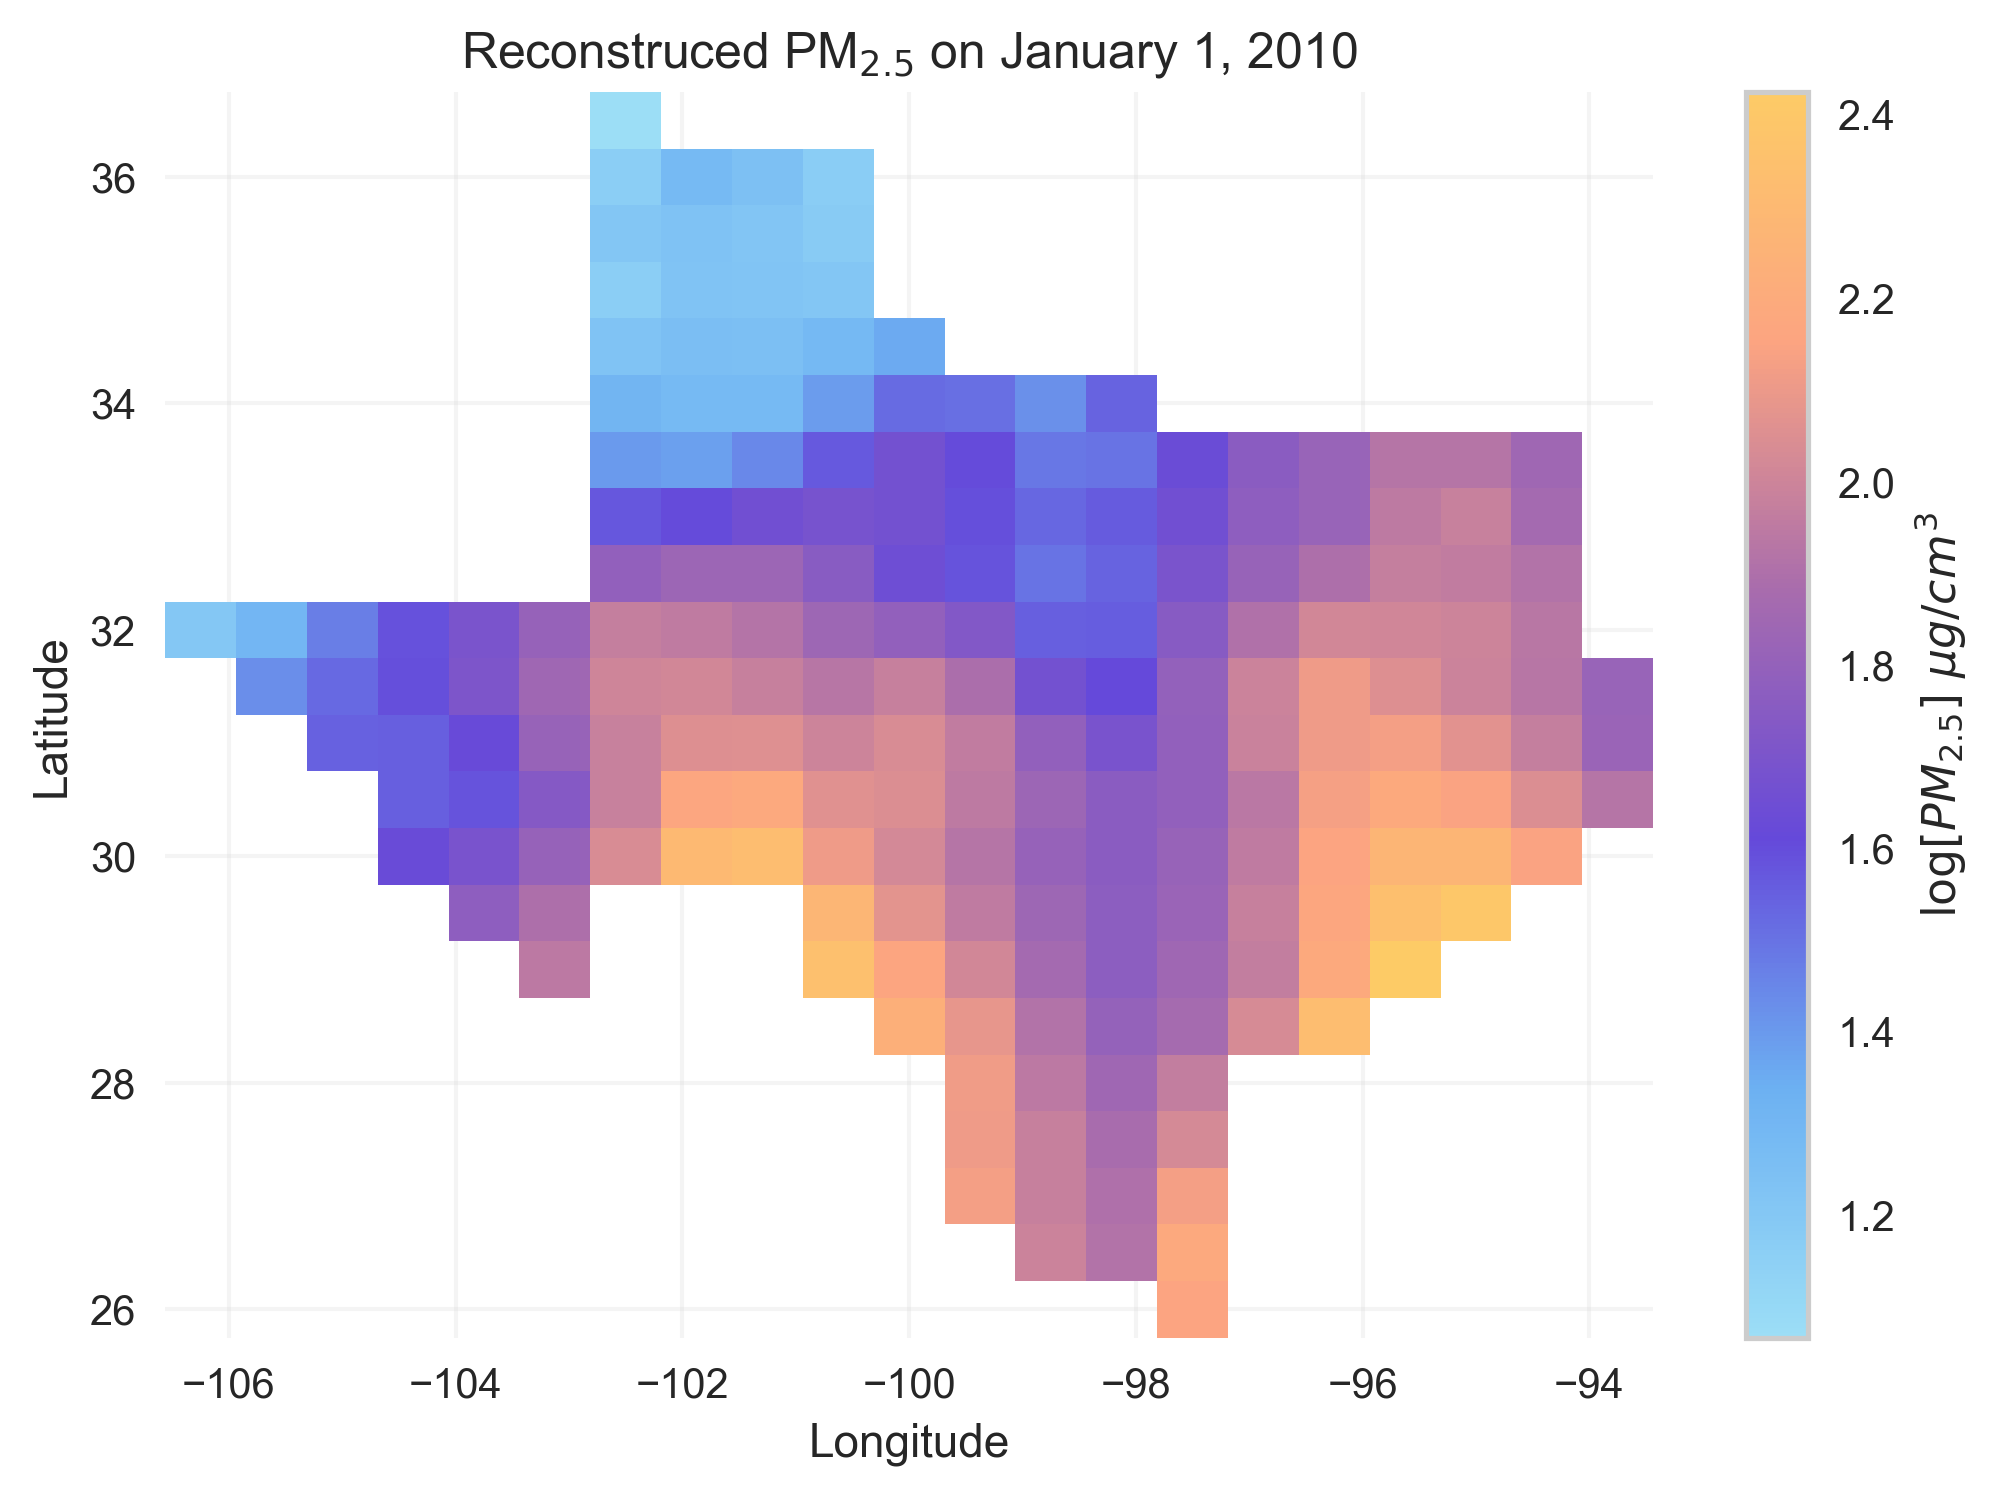

In [13]:
fig, ax = plt.subplots(dpi=300)

ds.sel(time='2010-01-01')['PM2.5'].plot(
    ax=ax, 
    cmap = announce,
    cbar_kwargs={'label': '$\log[PM_{2.5}] ~ \mu g/cm^3$'})

ax.grid(alpha=0.2)
ax.set_title('Reconstruced PM$_{2.5}$ on January 1, 2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Feature Selection

120 features is far too many features. Further, some of the columns make up the PM2.5 column and many are not directly measurable by ground stations. The goal of this project is to work on data reminiscent of ground data and then compare the performance of several of the algorithms across the same time and spatial domain with the same features. A future study could then replicate the results but with data measured with satellites and weather stations.

Here, we will pick out a subset of the variables which are directly measurable and then choose the top `n` features with the highest mutual information value. There is no fundamental reason that we chose mutual information over Pearson's R.

First we will need to cut down the data to those columns that we need, split into the testing, training, and validation sets, and then run feature selection. The feature selection will be run only on the training set. The columns kept from the training set will be applied to the validation and testing sets.

A note on the train, test, validation split: The atmosphere has a memory. One can imagine that the concentration of PM2.5 on a Monday might affect the concentration on a Tuesday. Similar things can be said for other data variables. I do not know how, but it is possible that somehow some of the algorithms could learn a correlation between these variables, depending on which time componenet is used. To prevent the learned estimators from cheating when predicting the testing data, I wanted to ensure that there was space in time between the training and testing sets. That is why I did not use the normal `train_test_split` function provided by `scikit-learn`. Further, the validation set here is used only to check the out-of-sample performance **after** the algorithms are trained, meaning this validation set is not used in any of the algorithms. It is possible that some of the algorithms use a validation set, but that set would be a subset of the training set. Because the validation set made here is used to check the out-of-sample performance, it is possible that some of the actions taken could be influenced by those values, so the validation set should be considered to be a part of the training set. The final values reported at the end of this study will be reported on the testing set. The testing set will be run *exactly* once.

In [14]:
features_to_keep = [
    'PS',
    'QV2M',
    'QV10M',
    'T2M',
    'T10M',
    'U2M',
    'V2M',
    'U50M',
    'V50M',
    'U10M',
    'V10M',
    'TQL',
    'TQI',
    'TQV',
    'CLDTOT',
    'PM2.5',
    'AODANA',
    'ALBEDO',
    'TS',
    'MonthSin',
    'MonthCos',
    'TPRECMAX',
    'DISPH',
    'EMIS'
    ]

In [15]:
df = ds[features_to_keep]
df

<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/24)
    PS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV2M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T10M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    U2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    TS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    DISPH        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [16]:
train = df.sel(time=slice("2010", "2017")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
val = df.sel(time=slice("2018", "2019-06")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
test = df.sel(time=slice("2019-07", "2020")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)

Because the dataset was clipped to Texas, there are a lot of NaNs. We can just drop those since those are for location that are not in Texas.


In [17]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
train.head()

lat    lon        PS  QV2M  QV10M    T2M   T10M   U2M   V2M  \
time                                                                       
2010-01-01 26.00 -97.50 102550.84  0.01   0.01 286.15 286.14  1.17 -4.50   
2010-01-02 26.00 -97.50 102471.00  0.01   0.01 285.52 286.11 -1.47 -0.55   
2010-01-03 26.00 -97.50 101837.12  0.01   0.01 289.48 289.97 -0.82  0.06   
2010-01-04 26.00 -97.50 102421.00  0.01   0.01 287.70 287.63 -0.90 -4.72   
2010-01-05 26.00 -97.50 102816.41  0.01   0.01 284.08 284.30 -1.30 -2.23   

            U50M  ...  CLDTOT  PM2.5  AODANA  ALBEDO     TS  MonthSin  \
time              ...                                                   
2010-01-01  1.90  ...    0.70   2.15   -2.30    0.17 286.53      0.50   
2010-01-02 -2.82  ...    0.77   1.83   -2.17    0.16 285.80      0.50   
2010-01-03 -2.22  ...    0.84   1.98   -1.76    0.16 289.42      0.50   
2010-01-04 -1.78  ...    0.87   2.66   -1.52    0.16 288.01      0.50   
2010-01-05 -2.58  ...    0.61   2.00   -2.10    0.17 284.90      0.50   

            MonthCos  TPRECMAX  DISPH  EMIS  
time                                         
2010-01-01      0.87      0.00   0.17  0.97  
2010-01-02      0.87      0.00   0.17  0.97  
2010-01-03      0.87      0.00   0.17  0.97  
2010-01-04      0.87      0.00   0.17  0.97  
2010-01-05      0.87      0.00   0.17  0.97  

[5 rows x 26 columns]

In [25]:
train['PM2.5 Climatology'] = np.nan

monthly_mean = train['PM2.5'].groupby(train.index.month).mean()
for month, group in train.groupby(train.index.month):
    train.loc[lambda df: df.index.month == month, 'PM2.5 Climatology'] = monthly_mean.loc[month]
    val.loc[lambda df: df.index.month == month, 'PM2.5 Climatology'] = monthly_mean.loc[month]
    test.loc[lambda df: df.index.month == month, 'PM2.5 Climatology'] = monthly_mean.loc[month]

In [27]:
val

lat     lon        PS  QV2M  QV10M    T2M   T10M   U2M   V2M  \
time                                                                        
2018-01-01 26.00  -97.50 103027.32  0.01   0.01 281.60 281.31  0.68 -7.23   
2018-01-02 26.00  -97.50 103106.41  0.00   0.00 277.44 277.21  2.25 -4.89   
2018-01-03 26.00  -97.50 102998.60  0.00   0.00 277.94 277.55  2.59 -5.89   
2018-01-04 26.00  -97.50 102689.46  0.00   0.00 280.40 281.42  0.35 -1.05   
2018-01-05 26.00  -97.50 102474.96  0.01   0.01 286.97 287.72 -1.35 -0.76   
...          ...     ...       ...   ...    ...    ...    ...   ...   ...   
2019-06-26 36.50 -102.50  87566.56  0.01   0.01 298.24 298.19  1.10  4.27   
2019-06-27 36.50 -102.50  87722.35  0.01   0.01 300.33 300.24  2.72  4.36   
2019-06-28 36.50 -102.50  87785.88  0.01   0.01 300.64 300.54  1.57  3.77   
2019-06-29 36.50 -102.50  87864.84  0.01   0.01 301.42 301.30  1.42  3.53   
2019-06-30 36.50 -102.50  87723.07  0.01   0.01 301.36 301.43  0.59  1.89   

            U50M  ...  PM2.5  AODANA  ALBEDO     TS  MonthSin  MonthCos  \
time              ...                                                     
2018-01-01  0.70  ...   2.91   -0.96    0.16 282.59      0.50      0.87   
2018-01-02  3.23  ...   2.45   -1.37    0.15 278.72      0.50      0.87   
2018-01-03  4.01  ...   2.48   -1.67    0.18 279.60      0.50      0.87   
2018-01-04  1.34  ...   2.16   -2.51    0.17 281.06      0.50      0.87   
2018-01-05 -2.90  ...   1.84   -1.87    0.16 287.22      0.50      0.87   
...          ...  ...    ...     ...     ...    ...       ...       ...   
2019-06-26  1.70  ...   2.47   -2.04    0.21 298.62      0.00     -1.00   
2019-06-27  5.56  ...   2.46   -2.07    0.20 300.88      0.00     -1.00   
2019-06-28  3.22  ...   2.47   -2.14    0.21 301.40      0.00     -1.00   
2019-06-29  3.14  ...   2.66   -2.27    0.21 302.19      0.00     -1.00   
2019-06-30  2.29  ...   2.24   -2.43    0.21 302.42      0.00     -1.00   

            TPRECMAX  DISPH  EMIS  PM2.5 Climatology  
time                                                  
2018-01-01      0.00   0.17  0.97               1.88  
2018-01-02      0.00   0.17  0.97               1.88  
2018-01-03      0.00   0.17  0.97               1.88  
2018-01-04      0.00   0.17  0.97               1.88  
2018-01-05      0.00   0.17  0.97               1.88  
...              ...    ...   ...                ...  
2019-06-26      0.00   0.21  0.97               2.63  
2019-06-27      0.00   0.21  0.97               2.63  
2019-06-28      0.00   0.21  0.97               2.63  
2019-06-29      0.00   0.21  0.97               2.63  
2019-06-30      0.00   0.21  0.97               2.63  

[113022 rows x 27 columns]

In [21]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

def make_feature_selector(df, endogenous, k=15):
    """ Create a SelectKBest model for the dataset
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe holding the exogenous (independent) and endogenous (dependent) variables
    endogenous: str
        A string indicating which variable is the endogenous (dependent) variable
    k: int, default 15
        The number of desired features (columns of the dataframe, exogenous variables) to keep

    Returns
    ----------
    features: sklearn.feature_selection.SelectKBest
        A fitted SelectKBest model
    """
    X, y = df.drop(endogenous, axis=1), df[endogenous]
    features = SelectKBest(mutual_info_regression, k=k)
    features.fit(X, y)
    return features

def subset_features_v1(df, features):
    """ Extract the desired features from a dataframe
    
    Parameters
    ----------
    df : a pandas dataframe
        The dataframe holding the exogenous (independent) variables and excluding the endogenous (dependent) variable
    features: sklearn.feature_selection._BaseFilter
        A fitted sklearn.feature_selection._BaseFilter like SelectKBest

    Returns
    ----------
    X: pandas.DataFrame
        A subset of `df` containing only those features selected by `features`
    """
    
    return df.loc[:, features.get_support()]

def filter_features(df, features, correlation_threshold = 0.75):
    """ Extract the desired features from a dataframe
    
    Parameters
    ----------
    df : a pandas dataframe
        The dataframe holding the exogenous (independent) variables and excluding the endogenous (dependent) variable
    features: sklearn.feature_selection._BaseFilter
        A fitted sklearn.feature_selection._BaseFilter like SelectKBest
    correlation_threshold: float, default 0.75
        If a feature's Pearson correlation value with another potetnial feature
        is greater than this value, then we will not include it. However, we will always output K features.
        Selection happens like this:
            - start with an empty set of features
            - if a candidate feature does not have a correlation value > correlation_threshold, add it to the set
            - do this until K is reached, or we are out of features
            - if we have less than K features, start adding them again based on the MI, 
                disregarging the correlation threshold until K is reached

    Returns
    ----------
    X: pandas.DataFrame
        A subset of `df` containing only those features selected by `features`
    """
    correlation = df.corr()
    
    argsort = np.argsort(features.scores_)[::-1]
    sorted_mi_features = train.drop('PM2.5', axis=1).columns.values[argsort]
    
    filtered_features = []
    for potential_feautre in sorted_mi_features:
        passes_threshold = True
        for existing_feautre in filtered_features:
            corr = correlation.loc[potential_feautre][existing_feautre]
            if corr > correlation_threshold:
                passes_threshold = False
                
        if passes_threshold:        
            filtered_features.append(potential_feautre)
            
        if len(filtered_features) == features.k:
            break
    
    return filtered_features

In [22]:
import pickle

feature_file = os.path.join(paths.models, 'feature_selection.pcl')

if os.path.exists(feature_file):
    with open(feature_file, 'rb') as f:
        features = pickle.load(f)
else:
    features = make_feature_selector(train, 'PM2.5', k=10)
    with open(feature_file, 'wb') as f:
        pickle.dump(features, f)

In [28]:
filtered_features = filter_features(train.drop('PM2.5', axis=1), features)
x_train, y_train = train.drop('PM2.5', axis=1)[filtered_features], train['PM2.5']
x_val, y_val = val.drop('PM2.5', axis=1)[filtered_features], val['PM2.5']
x_test, y_test = test.drop('PM2.5', axis=1)[filtered_features], test['PM2.5']

In [29]:
for i in filtered_features:
    print(i)

AODANA
QV10M
PM2.5 Climatology
MonthCos
ALBEDO
DISPH
EMIS
TPRECMAX
PS
lat


# Modeling

## Training

### Hyper Parameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [36]:
params={
    'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)],
    'learning_rate': np.arange(0.2, 2, .2),
    'loss': ['linear', 'square', 'exponential'],
    'n_estimators': np.arange(50, 550, 50)
}

ada_grid = GridSearchCV(
    AdaBoostRegressor(), 
    params, 
    cv=10, 
    scoring=mc.scoring, 
    refit='neg_root_mean_squared_error',
    n_jobs=-1)

ada_grid.fit(x_train.loc['2010'], y_train.loc['2010'])

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=10, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(max_depth=3),
                                            DecisionTreeRegressor(max_depth=4),
                                            DecisionTreeRegressor(max_depth=5)],
                         'learning_rate': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [37]:
from joblib import dump, load
dump(ada_grid, os.path.join(paths.models, 'ada_grid.pcl'))

['experiments/climatology/models/ada_grid.pcl']

### Training

In [32]:
from model_collection import ModelCollection, ModelStack

In [33]:
import importlib
import sys
importlib.reload(sys.modules['model_collection'])

<module 'model_collection' from '/Users/kyle/Documents/PM25/model_collection.py'>

In [34]:
# lme_group = 'Season'
# formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|Location/{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

# locations = train['lat'].astype(str) + train['lon'].astype(str)
# locations.name = 'Location'

# mc = ModelCollection(
#     x_train, y_train, 
#     lme_dependent='PM', 
#     lme_formula=formula, 
#     lme_group=lme_group, 
#     lme_locations=locations)


In [38]:
mc = ModelCollection(x_train, y_train)

In [39]:
mc.models['Ada Boost'] = ada_grid.best_estimator_

In [40]:
cv_scores = mc.compute_cross_validation_scores()

  0%|          | 0/16 [00:00<?, ?it/s]

[12:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:59:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [77]:
mc.compute_cross_validation_scores_for_model('Ada Boost')

{'Linear Regression': {'fit_time': array([0.93786502, 0.95873213, 0.94436097, 0.95688081, 0.9467442 ,
         0.94590998, 0.95197272, 0.94796801, 0.92350483, 0.94681883]),
  'score_time': array([0.00980091, 0.01427102, 0.01152205, 0.01284814, 0.01279783,
         0.01365304, 0.01240921, 0.01315808, 0.01696992, 0.01271915]),
  'test_r2': array([0.45508199, 0.51079638, 0.52543988, 0.54366229, 0.49892406,
         0.50814476, 0.4385816 , 0.50237218, 0.5811372 , 0.50962674]),
  'test_neg_mean_absolute_error': array([-0.2877394 , -0.26172792, -0.257409  , -0.2607314 , -0.26303316,
         -0.26613268, -0.27953126, -0.27269428, -0.27708204, -0.32001513]),
  'test_neg_root_mean_squared_error': array([-0.36541325, -0.33990967, -0.33983544, -0.34560366, -0.34973812,
         -0.35297557, -0.36409153, -0.36069393, -0.36762805, -0.40183403])},
 'Elastic Net': {'fit_time': array([89.6250422 , 92.38371205, 92.38060284, 92.31522298, 92.21496391,
         93.30569506, 92.28498602, 92.3031919 , 92.8

In [78]:
mc.fit_model('Ada Boost')

115.71951103210449

In [41]:
fit_times = mc.fit()

  0%|          | 0/16 [00:00<?, ?it/s]

[15:12:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [42]:
mc.save(os.path.join(paths.models, 'texas-2010-17.joblib'))

In [43]:
mc.save_model_cross_val_scores(os.path.join(paths.models, 'texas-2010-17_scores.p'))

In [82]:
plt.rcParams['text.usetex'] = False

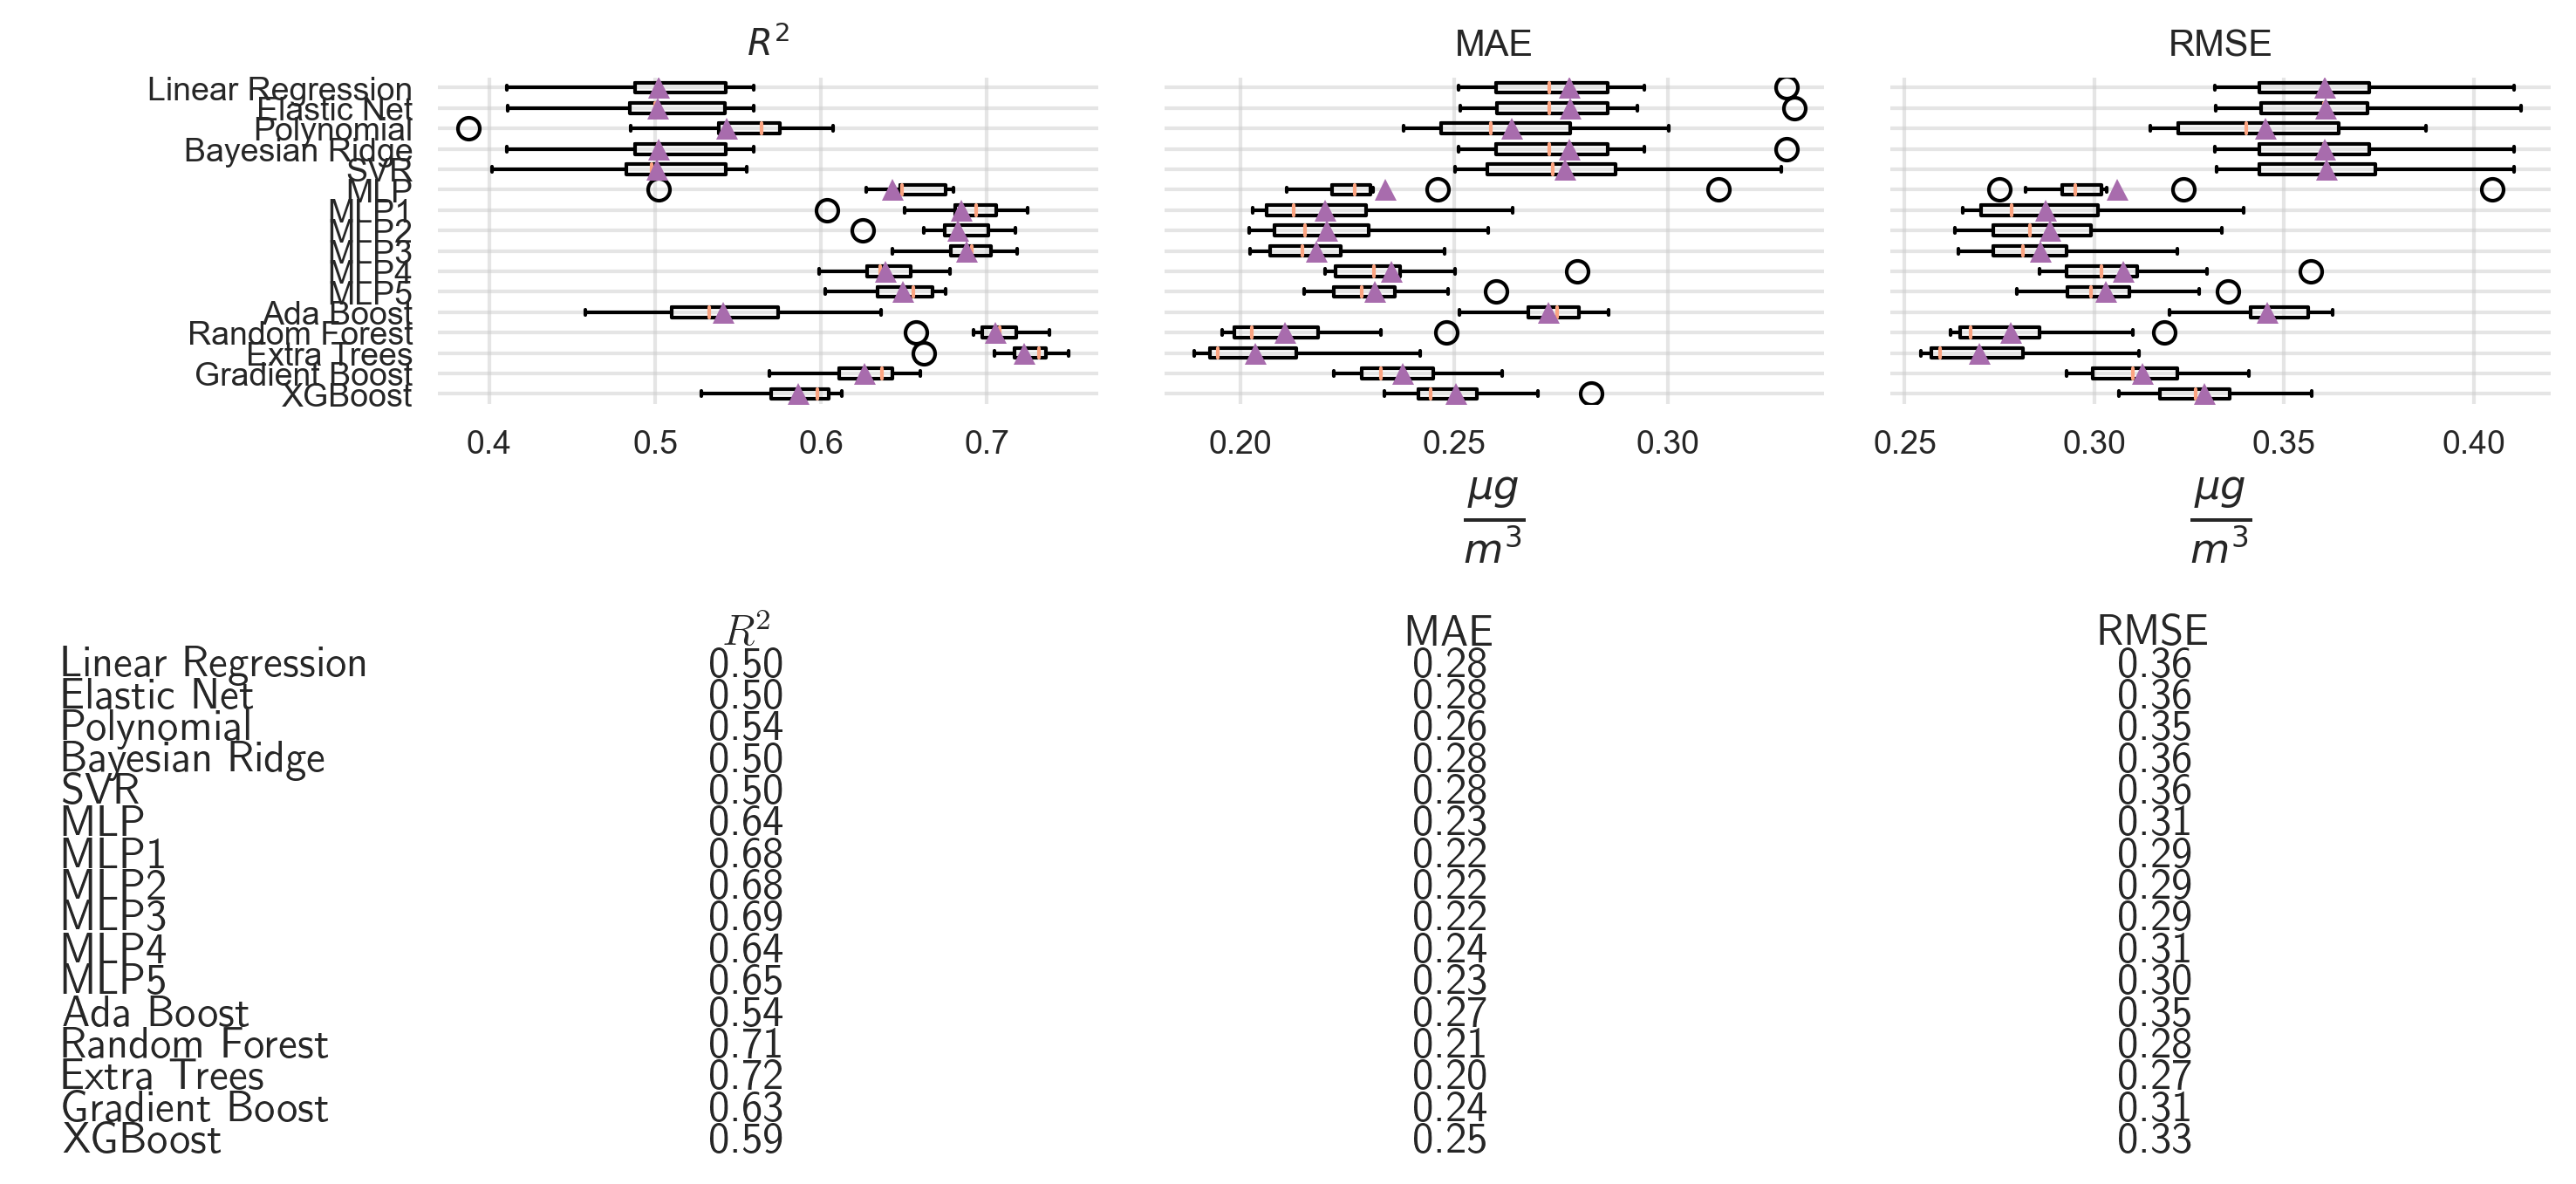

In [44]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=True, filename=os.path.join(paths.figures, 'scores-2010-17.png'), fs=9);

In [23]:
# mc = ModelCollection.__new__(ModelCollection)
mc = ModelCollection(x_train, y_train)
mc.load_model_cross_val_scores(os.path.join(paths.models, 'texas-2010-17_scores.p'))
mc.load(os.path.join(paths.models, 'texas-2010-17.joblib'))

[19:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Getting Polynomial Features

In [86]:
pf = mc.models['Polynomial'].steps[0][1].fit(x_val)
pf

PolynomialFeatures()

In [87]:
pf.get_feature_names(x_val.columns)

['1',
 'AODANA',
 'QV10M',
 'MonthCos',
 'ALBEDO',
 'DISPH',
 'EMIS',
 'TPRECMAX',
 'PS',
 'lat',
 'V2M',
 'AODANA^2',
 'AODANA QV10M',
 'AODANA MonthCos',
 'AODANA ALBEDO',
 'AODANA DISPH',
 'AODANA EMIS',
 'AODANA TPRECMAX',
 'AODANA PS',
 'AODANA lat',
 'AODANA V2M',
 'QV10M^2',
 'QV10M MonthCos',
 'QV10M ALBEDO',
 'QV10M DISPH',
 'QV10M EMIS',
 'QV10M TPRECMAX',
 'QV10M PS',
 'QV10M lat',
 'QV10M V2M',
 'MonthCos^2',
 'MonthCos ALBEDO',
 'MonthCos DISPH',
 'MonthCos EMIS',
 'MonthCos TPRECMAX',
 'MonthCos PS',
 'MonthCos lat',
 'MonthCos V2M',
 'ALBEDO^2',
 'ALBEDO DISPH',
 'ALBEDO EMIS',
 'ALBEDO TPRECMAX',
 'ALBEDO PS',
 'ALBEDO lat',
 'ALBEDO V2M',
 'DISPH^2',
 'DISPH EMIS',
 'DISPH TPRECMAX',
 'DISPH PS',
 'DISPH lat',
 'DISPH V2M',
 'EMIS^2',
 'EMIS TPRECMAX',
 'EMIS PS',
 'EMIS lat',
 'EMIS V2M',
 'TPRECMAX^2',
 'TPRECMAX PS',
 'TPRECMAX lat',
 'TPRECMAX V2M',
 'PS^2',
 'PS lat',
 'PS V2M',
 'lat^2',
 'lat V2M',
 'V2M^2']

### MGWR

In [33]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [34]:
gwr_x, gwr_y = train.loc['2010'][x_train.columns.values.tolist() + ['lat', 'lon']], y_train.loc['2010']
coords = list(zip(gwr_x.lat, gwr_x.lon))
gwr_x = gwr_x.drop(['lat', 'lon'], axis=1)
gwr_x, gwr_y = gwr_x.values, gwr_y.values.reshape(-1, 1)

In [35]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [36]:
# bw = Sel_BW(coords[:1000], gwr_y[:1000], gwr_x[:1000], fixed=True, spherical=True).search(criterion='AICc')
# print(bw)

In [37]:
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html#mgwr.gwr.GWR

# model = GWR(coords, gwr_y, gwr_x, bw=bw, fixed=True, kernel='gaussian')
# results = model.fit()

In [38]:
# results.summary()

### Linear Mixed Effect Things

In [39]:
def lme_experiment(x_train, y_train, locations, formula, model_file, scores_file):
    mc = ModelCollection(
        x_train, y_train, 
        lme_dependent='PM', 
        lme_formula=formula, 
        lme_group=lme_group, 
        lme_locations=locations)

    mc.fit_model('Linear Mixed Effect')
    mc.save(model_file)

    mc.compute_cross_validation_scores_for_model('Linear Mixed Effect')
    mc.save_model_cross_val_scores(scores_file)

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

for feature in ['AODANA', 'TQV', 'T2M', 'QV10M']:
    for lme_group in ['DoY', 'Month', 'Season', 'Location']:
        formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + {feature}|{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

        fname = os.path.join(paths.lme_models, f'{feature}_{lme_group}')
        lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')

for lme_group in ['DoY', 'Month', 'Season']:
    formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + AODANA|Location/{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

    fname = os.path.join(paths.lme_models, f'nested_location_{lme_group}')
    lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|DoY)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'DoY': 366.0}

Log-likelihood: -163071.886 	 AIC: 326143.772

Random effects:

                 Name  Var  Std
DoY       (Intercept) 0.02 0.13
DoY            AODANA 0.01 0.10
Residual              0.10 0.32

             IV1     IV2  Corr
DoY  (Intercept)  AODANA  0.17

Fixed effects:

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Month)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Month': 12.0}

Log-likelihood: -182237.461 	 AIC: 364474.922

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.04 0.21
Month          AODANA 0.01 0.08
Residual              0.11 0.33

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Season)+AODANA+ALBEDO+TS+MonthCos+DISPH



In [43]:
cv_scores = {}

with open(os.path.join(paths.models, 'texas-2010-17_scores.p'), 'rb') as f: 
    global_scores = pickle.load(f)

for feature in ['AODANA', 'TQV', 'T2M', 'QV10M']:
    for lme_group in ['DoY', 'Month', 'Season', 'Location']:
        fname = os.path.join(paths.lme_models, f'{feature}_{lme_group}.p')

        with open(fname, 'rb') as f: 
            scores = pickle.load(f)
        title = lme_group.capitalize()
        if title == 'Doy':
            title = 'Day of Year'
        title = f'{feature} | {title}'
        cv_scores[title] = scores['Linear Mixed Effect']


for lme_group in ['DoY', 'Month', 'Season']:
    fname = os.path.join(paths.lme_models, f'nested_location_{lme_group}.p')

    with open(fname, 'rb') as f: 
        scores = pickle.load(f)
    title = lme_group.capitalize()
    if title == 'Doy':
        title = 'Day of Year'
    title = f'AODANA | Location / {title}'
    cv_scores[title] = scores['Linear Mixed Effect']

cv_scores['Global Regression'] = global_scores["Linear Regression"]    
    

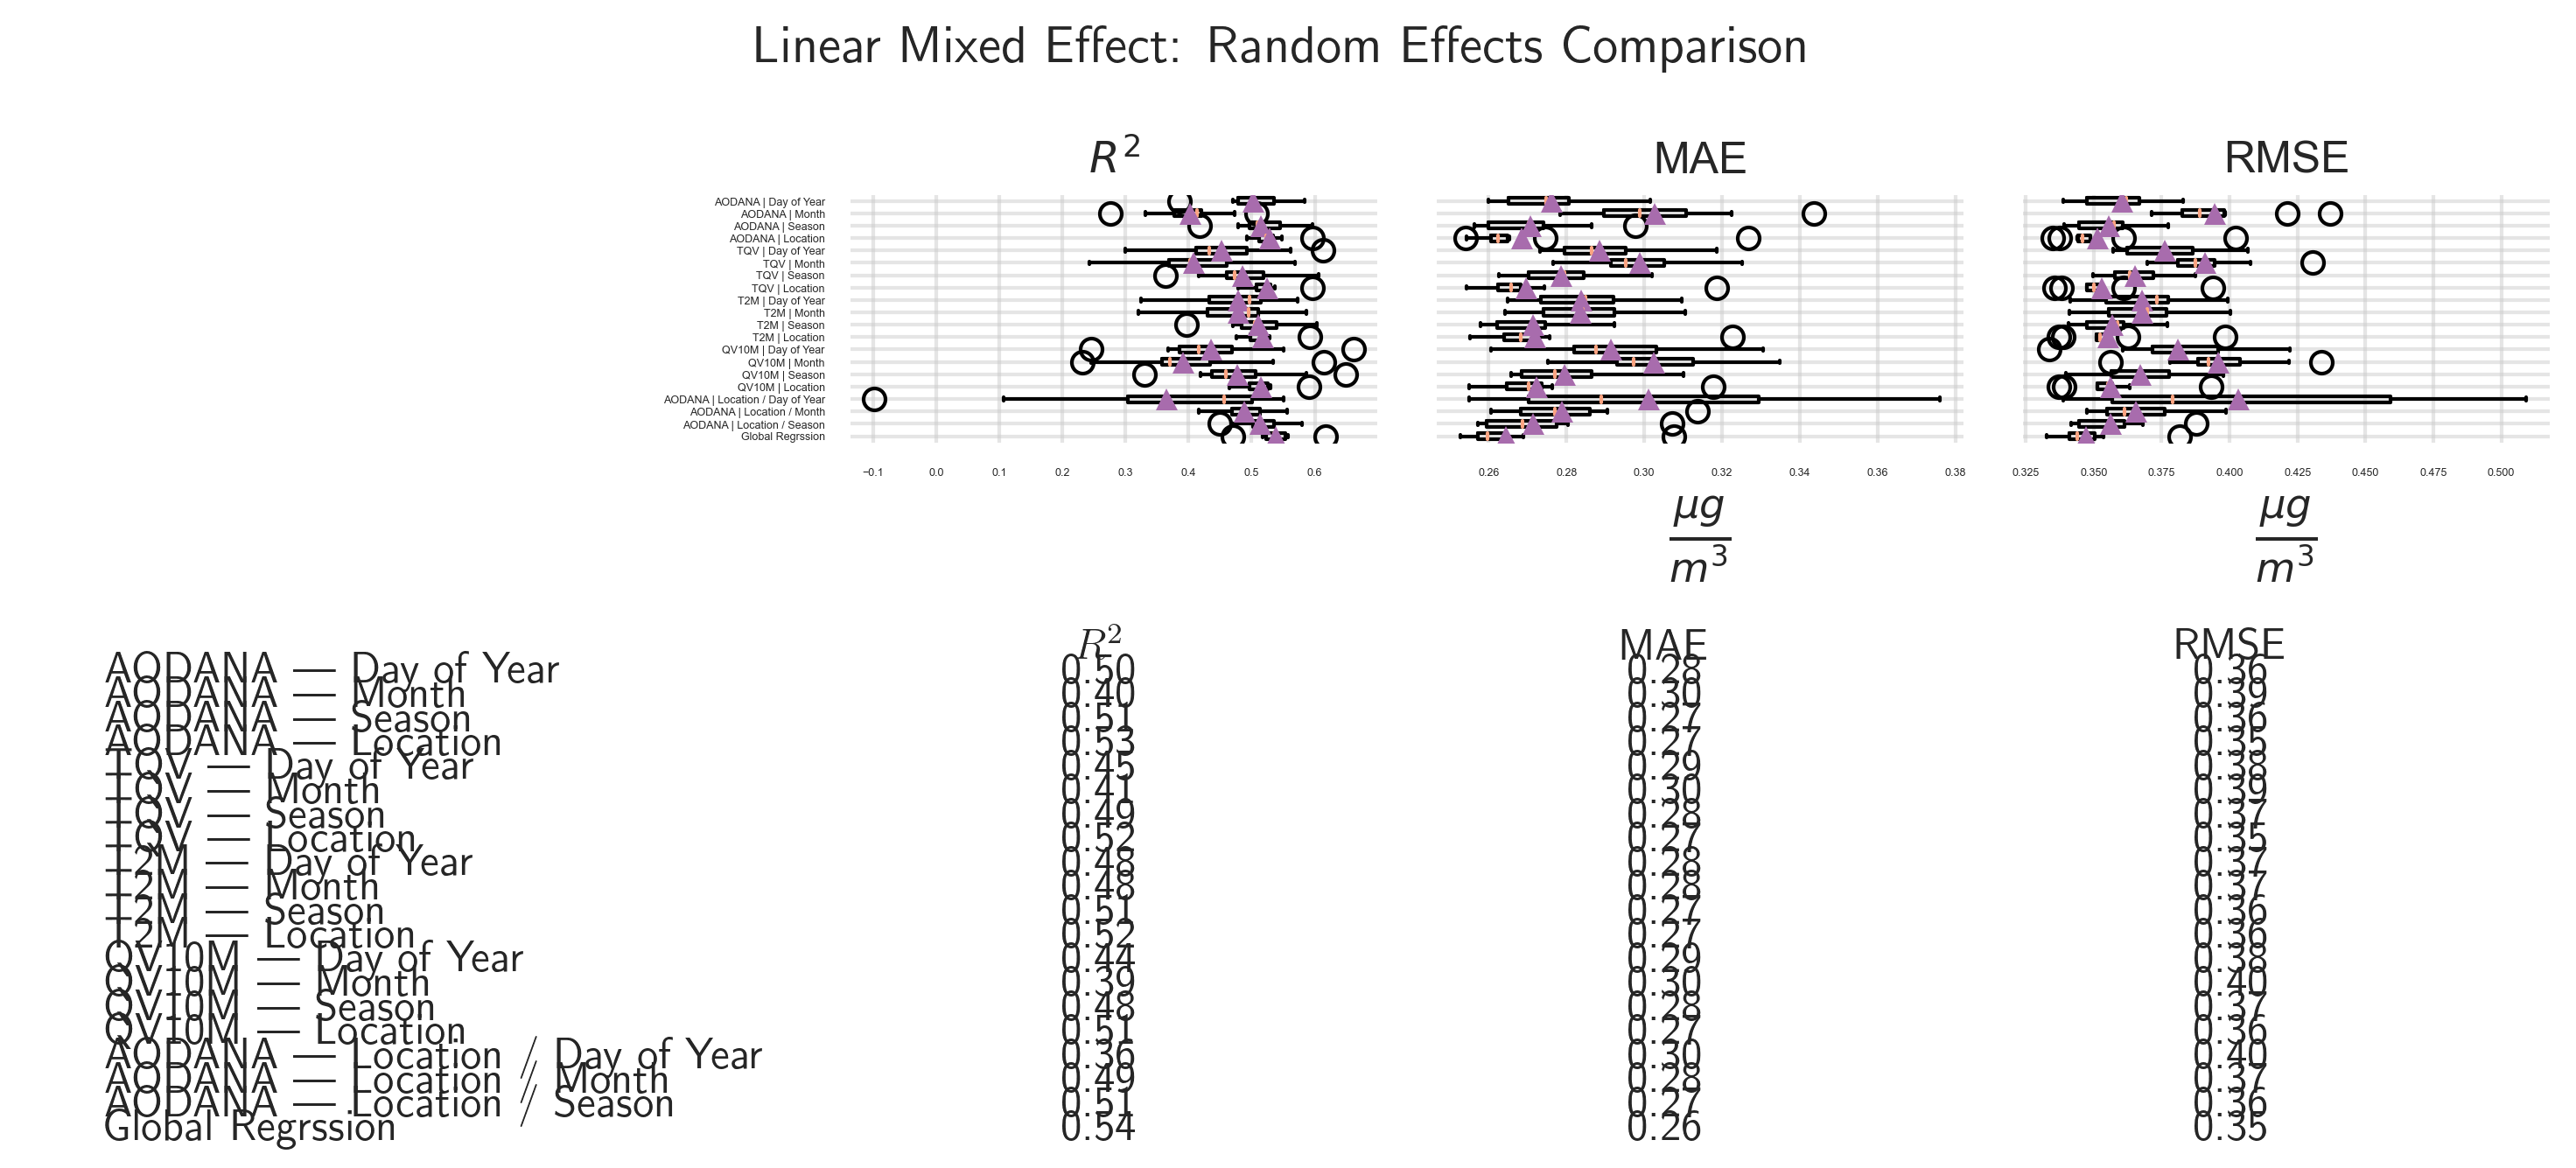

In [44]:
labels, scores = map(list, zip(*cv_scores.items()))
fig, _ = grouped_boxplot_with_table(scores, labels, fs=3, title_fontsize=12, table_fontsize=6, save=True, filename=os.path.join(paths.figures, 'lme_comparison.png'))
fig.suptitle('Linear Mixed Effect: Random Effects Comparison', y=1.05);

In [45]:
the_scores = pd.DataFrame(cv_scores)

In [46]:
print(the_scores.applymap(np.mean).T.to_csv())

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
AODANA | Day of Year,183.50517072677613,4.886820650100708,0.5015717315796964,-0.27606660415238793,-0.36034995242412104
AODANA | Month,185.84544057846068,5.584319519996643,0.4027524154561588,-0.30267493203043294,-0.39458584677587455
AODANA | Season,168.95697810649872,5.260464358329773,0.5143619381564478,-0.2707774694706265,-0.35570267876956807
AODANA | Location,160.51517136096953,4.685312581062317,0.5278669043567623,-0.26846257486123887,-0.3515060296963969
TQV | Day of Year,165.9167861223221,4.415987658500671,0.45264694713240167,-0.28852985027266825,-0.3762641155363948
TQV | Month,173.8059618473053,5.027958369255066,0.40838280262048743,-0.29889891744953856,-0.39105206444931084
TQV | Season,171.10904026031494,5.299122762680054,0.4852556897888302,-0.2784887725947359,-0.365331351891523
TQV | Location,158.48946032524108,4.865701723098755,0.5238163477051716,-0.26951141918358884,-0.35284764423533543
T2M

## Stacking

In [45]:
stack = ModelStack(mc, x_train, y_train, n = 3)

In [46]:
stack.fit()

In [47]:
stack.compute_scores(x_val, y_val)

{'r2': 0.6869601209748524,
 'rmse': 0.3144721170301097,
 'mae': 0.23768103965670623}

In [48]:
stack.save(os.path.join(paths.models, 'stack.joblib'))

In [187]:
stack = ModelStack.__new__(ModelStack)
stack.load(os.path.join(paths.models, 'stack.joblib'))

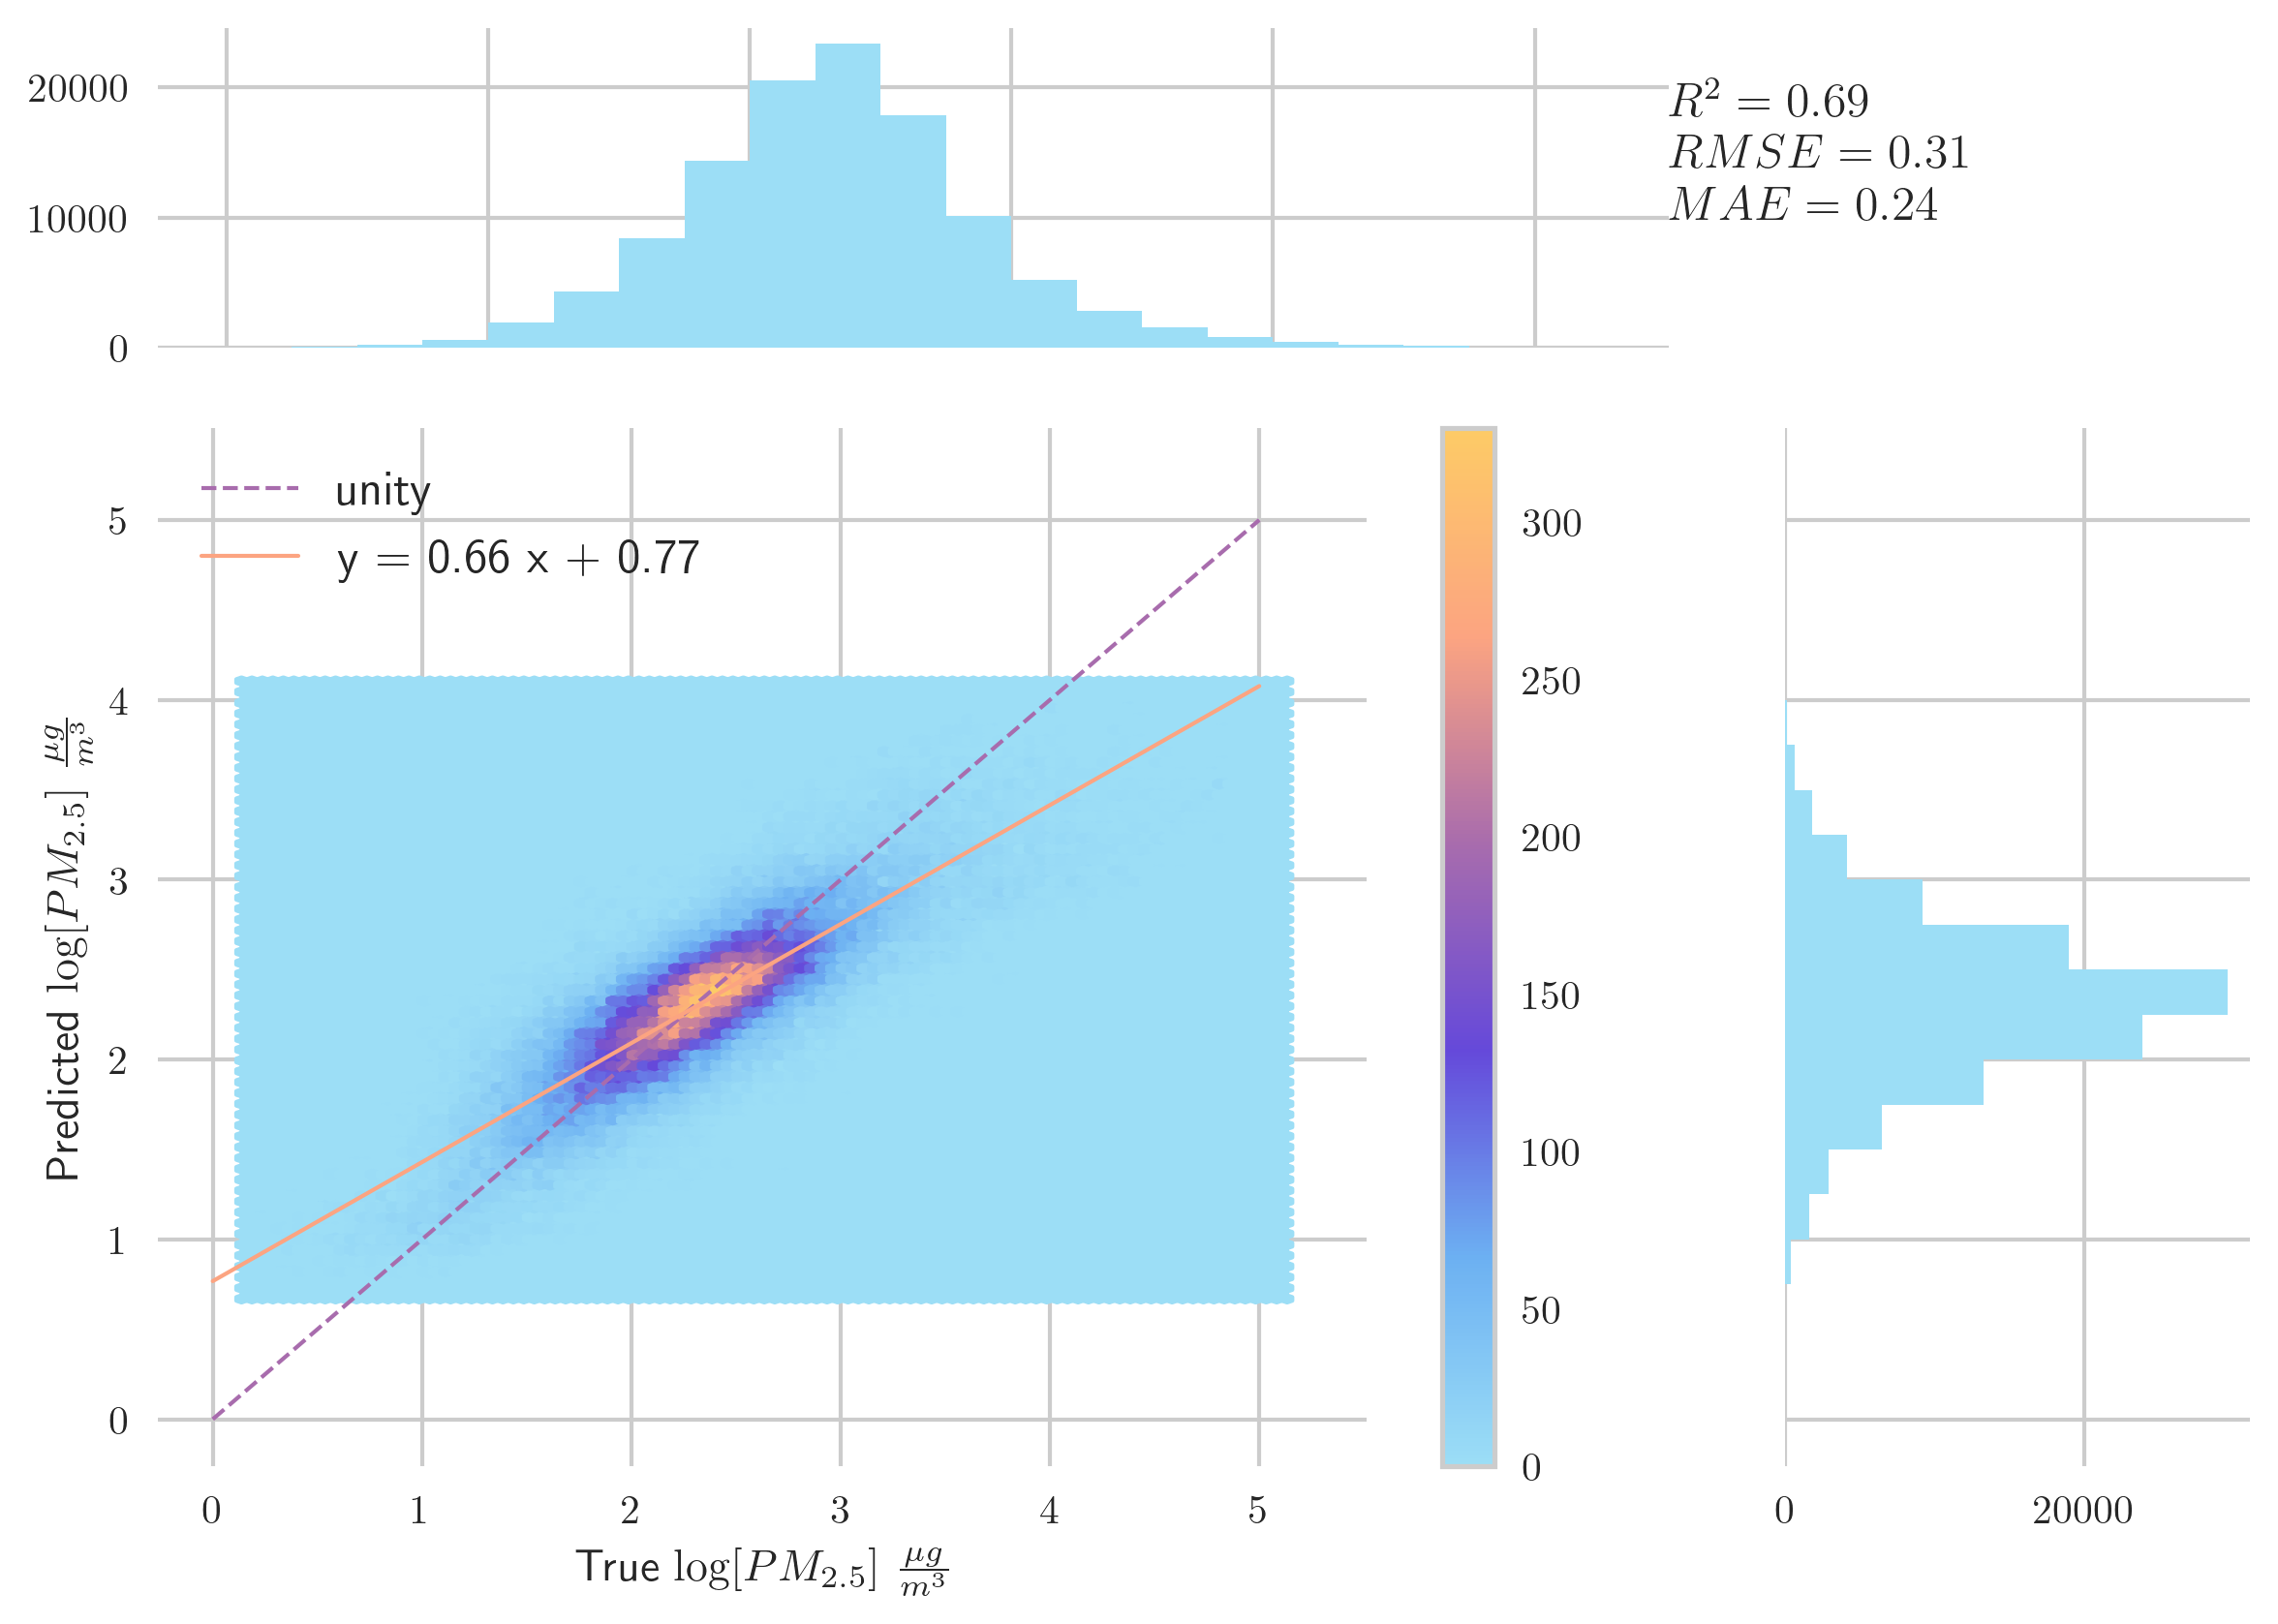

In [49]:
fig = plot_prediction_error(stack, x_val.copy(), y_val, cmap=announce, r2_ax_locx=1.25, r2_ax_locy=1.3)
fig.savefig(os.path.join(paths.figures, 'stacked.png'))

In [50]:
stack.voting_regressor_

VotingRegressor(estimators=[('Extra Trees', ExtraTreesRegressor(n_jobs=-1)),
                            ('Random Forest', RandomForestRegressor(n_jobs=-1)),
                            ('MLP2',
                             MLPRegressor(early_stopping=True,
                                          hidden_layer_sizes=(100, 50, 50, 50,
                                                              50),
                                          max_iter=100000))],
                n_jobs=-1)

## Feature Importance

In [91]:
imps = {}
columns = np.array(x_train.columns.values)
for name, model in mc.models.items():
    if getattr(model, 'feature_importances_', None) is not None:
        sort = np.argsort(model.feature_importances_)[::-1]
        imps[name] = [f'{a} ({b:0.2f})' for a, b in zip(columns[sort], model.feature_importances_[sort])]

In [92]:
print(pd.DataFrame(imps, index=np.arange(1, 11)).to_csv())

,Ada Boost,Random Forest,Extra Trees,Gradient Boost,XGBoost
1,AODANA (0.50),AODANA (0.57),AODANA (0.41),AODANA (0.78),AODANA (0.21)
2,TPRECMAX (0.15),QV10M (0.09),QV10M (0.13),QV10M (0.06),MonthCos (0.20)
3,QV10M (0.09),TPRECMAX (0.07),MonthCos (0.12),TPRECMAX (0.04),QV10M (0.15)
4,MonthCos (0.08),V2M (0.06),V2M (0.06),lat (0.04),PS (0.14)
5,EMIS (0.06),PS (0.05),PS (0.06),V2M (0.02),lat (0.09)
6,DISPH (0.05),lat (0.05),lat (0.06),PS (0.02),ALBEDO (0.09)
7,PS (0.03),ALBEDO (0.03),TPRECMAX (0.05),MonthCos (0.02),TPRECMAX (0.05)
8,lat (0.02),EMIS (0.03),EMIS (0.04),DISPH (0.00),V2M (0.03)
9,V2M (0.02),MonthCos (0.03),ALBEDO (0.04),EMIS (0.00),EMIS (0.02)
10,ALBEDO (0.02),DISPH (0.03),DISPH (0.03),ALBEDO (0.00),DISPH (0.02)



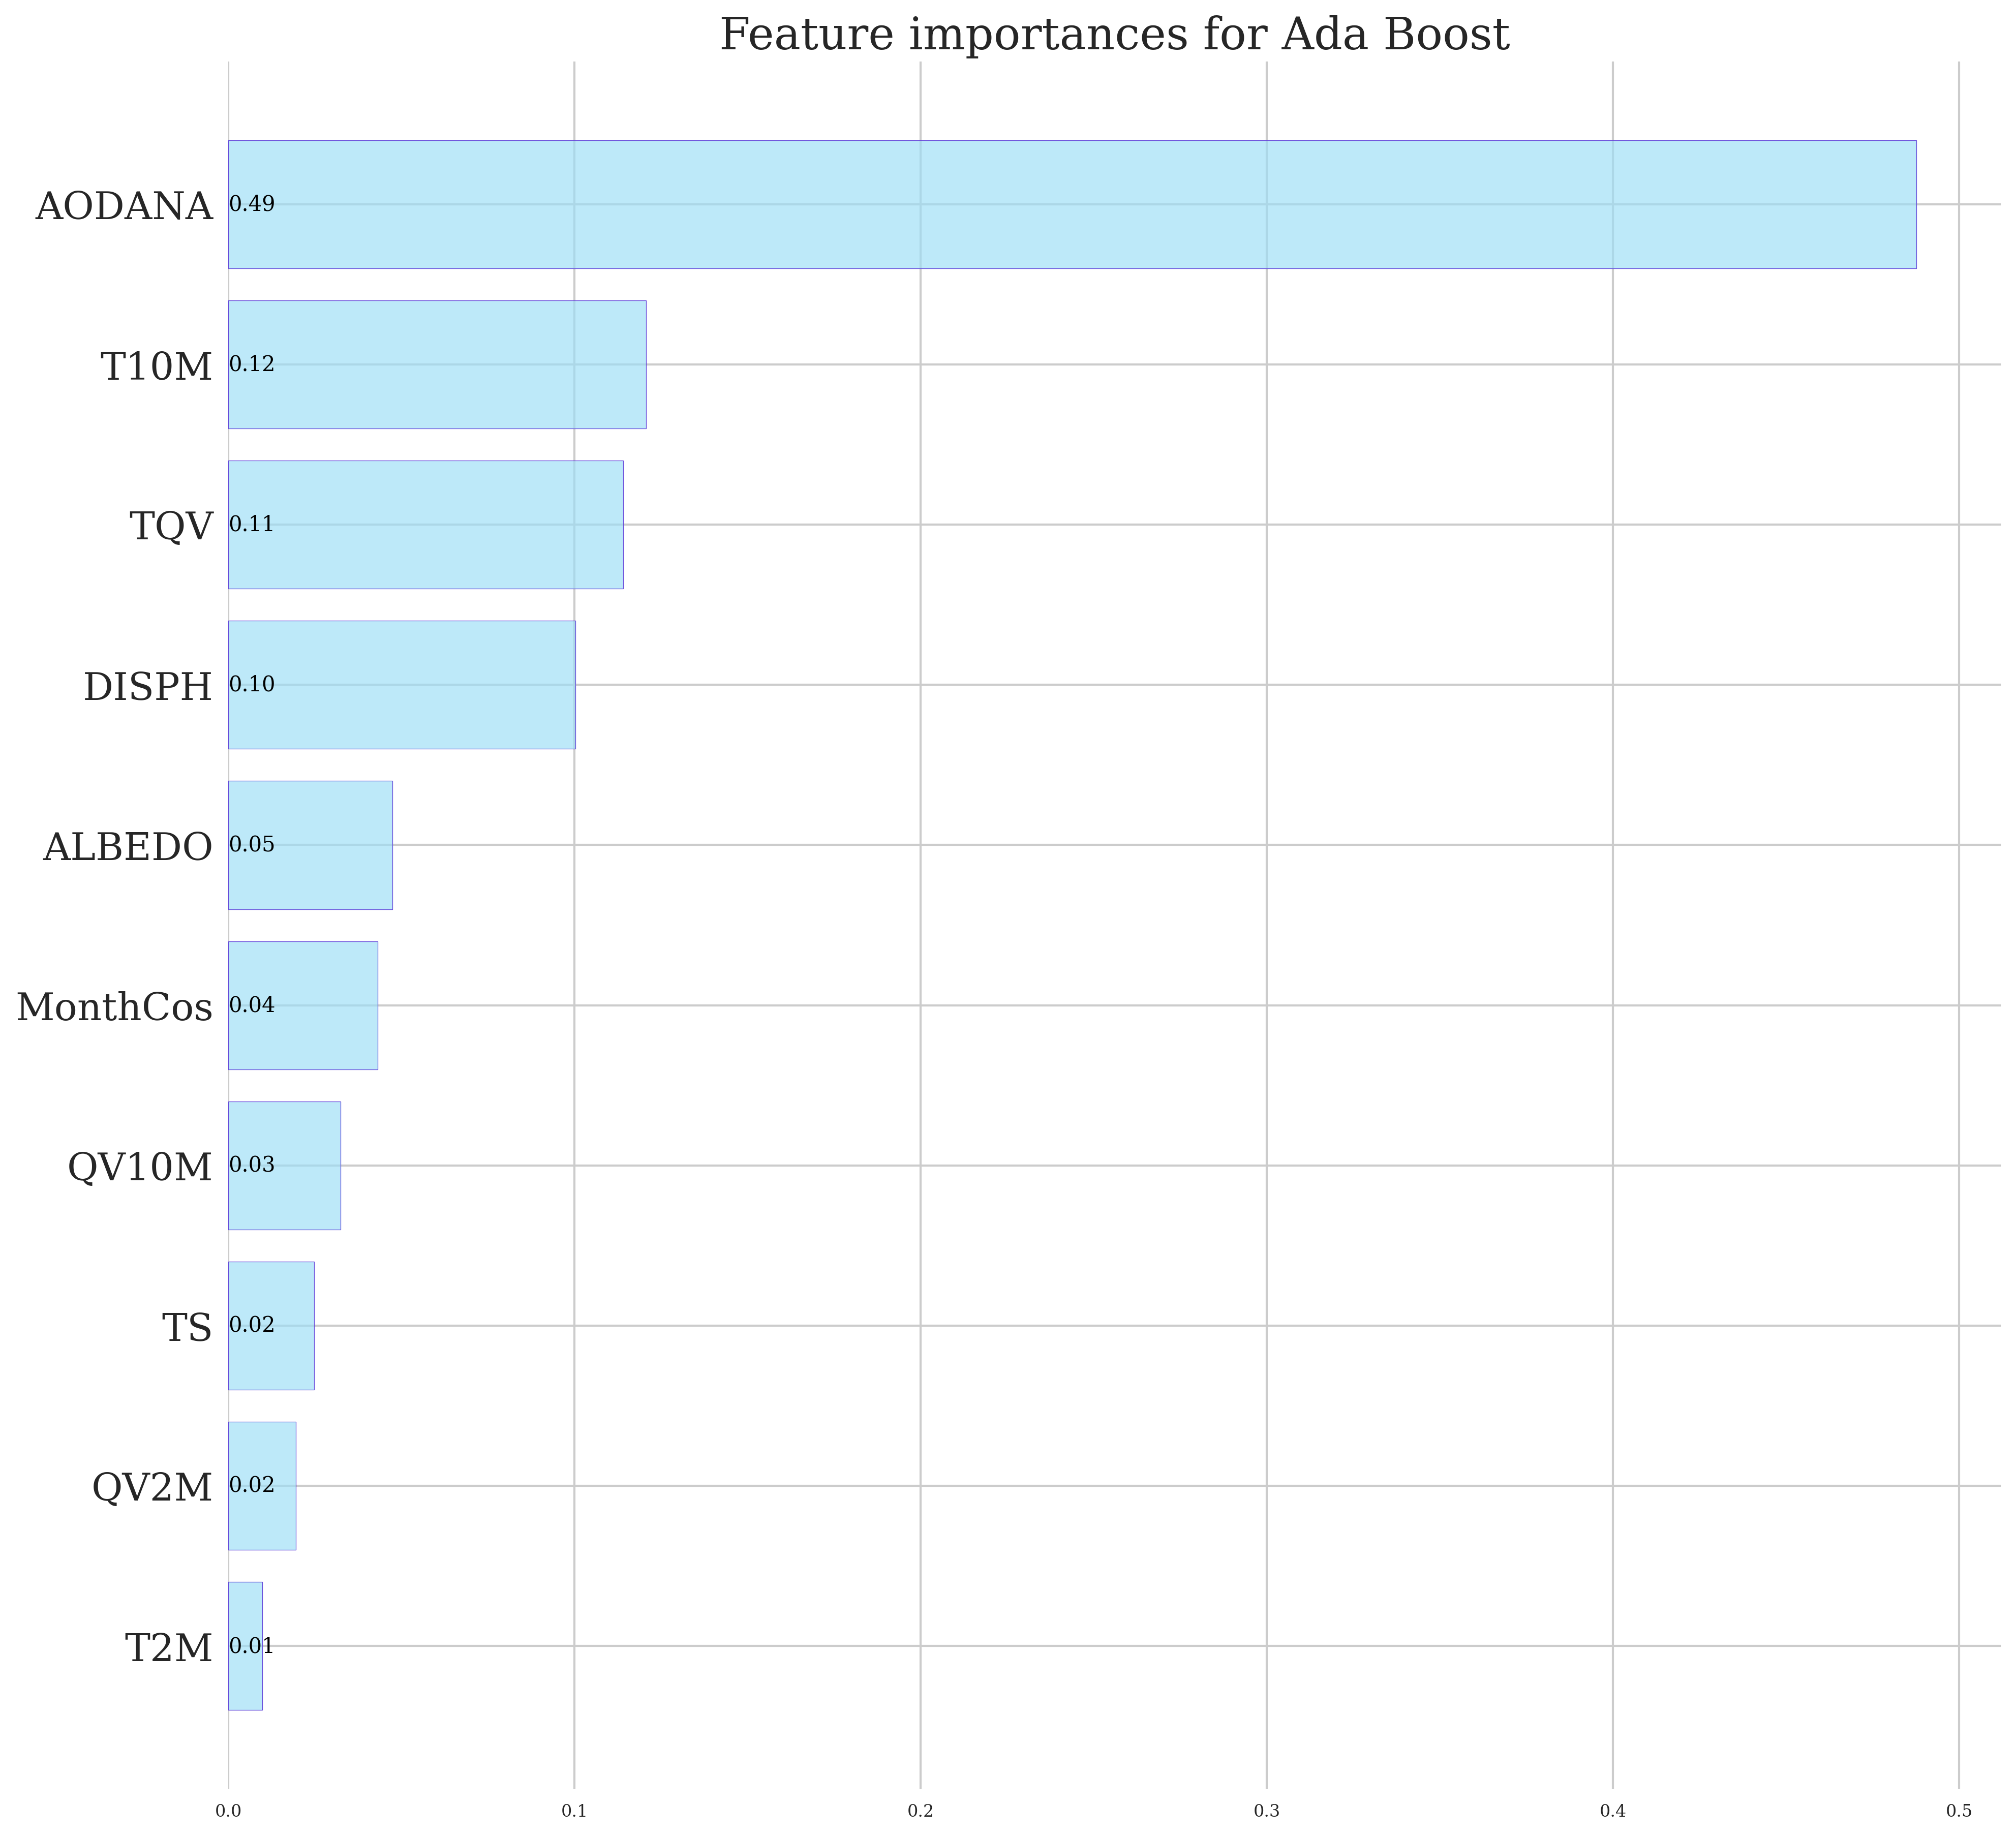

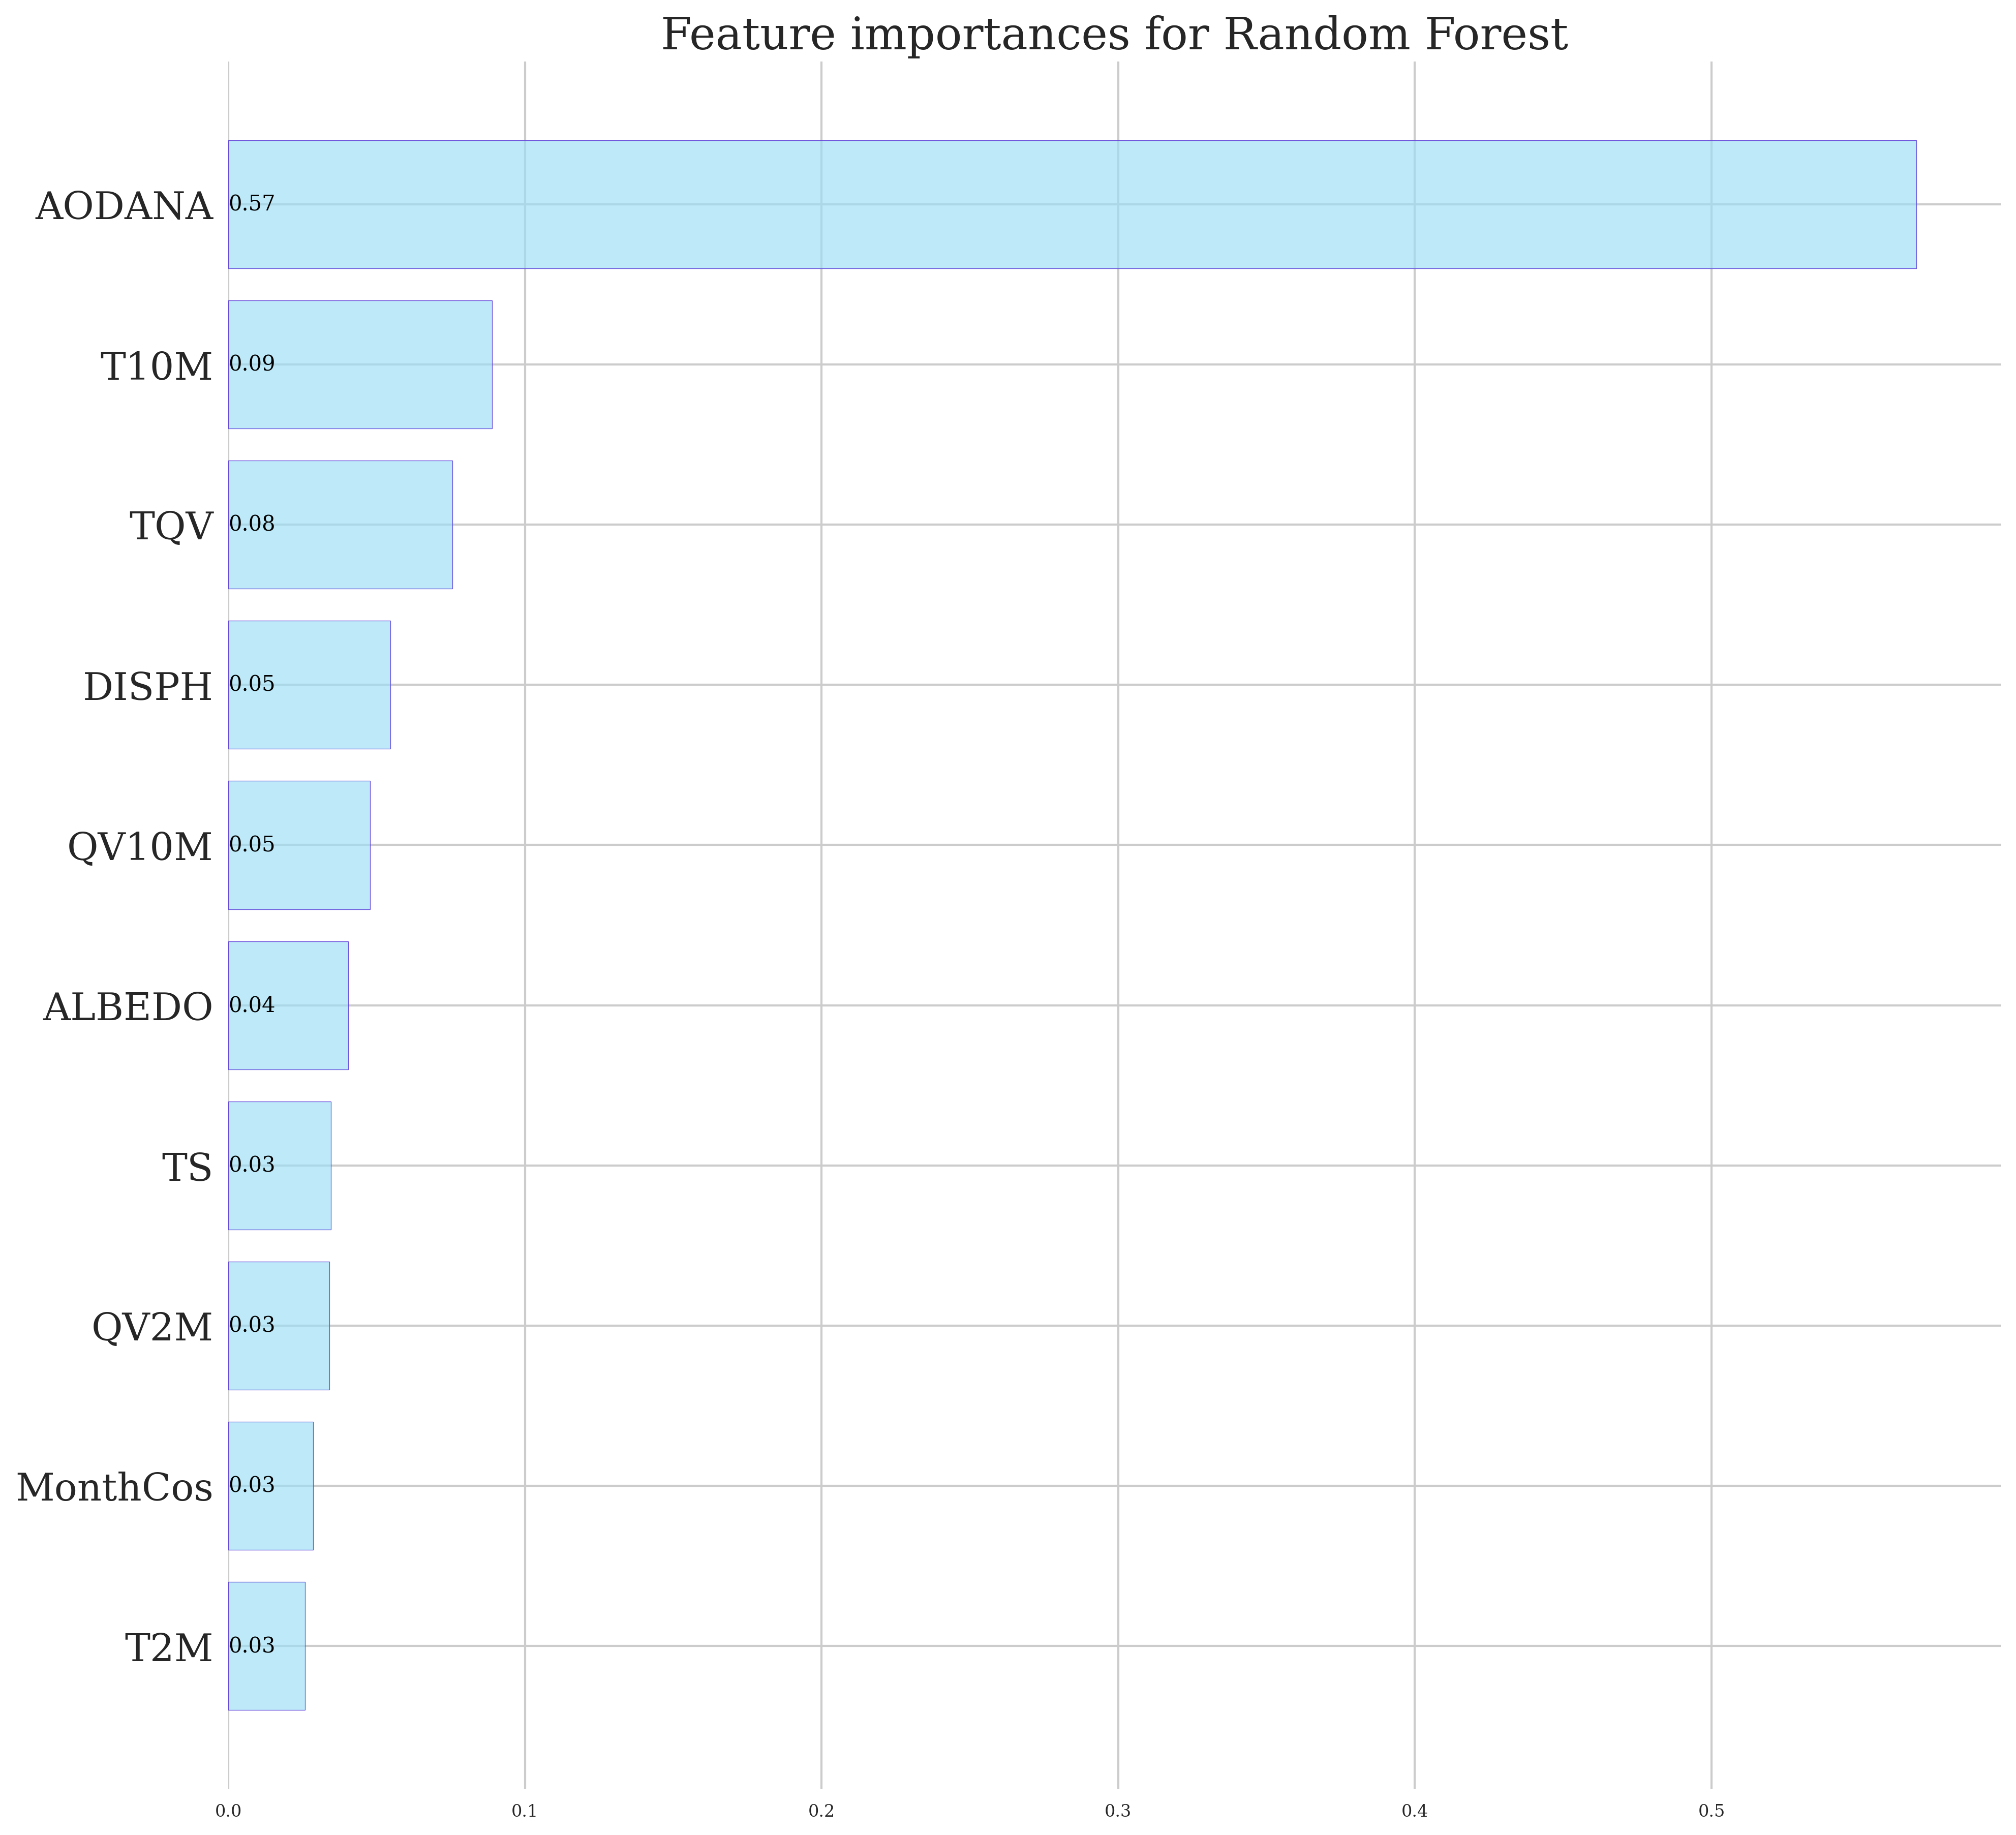

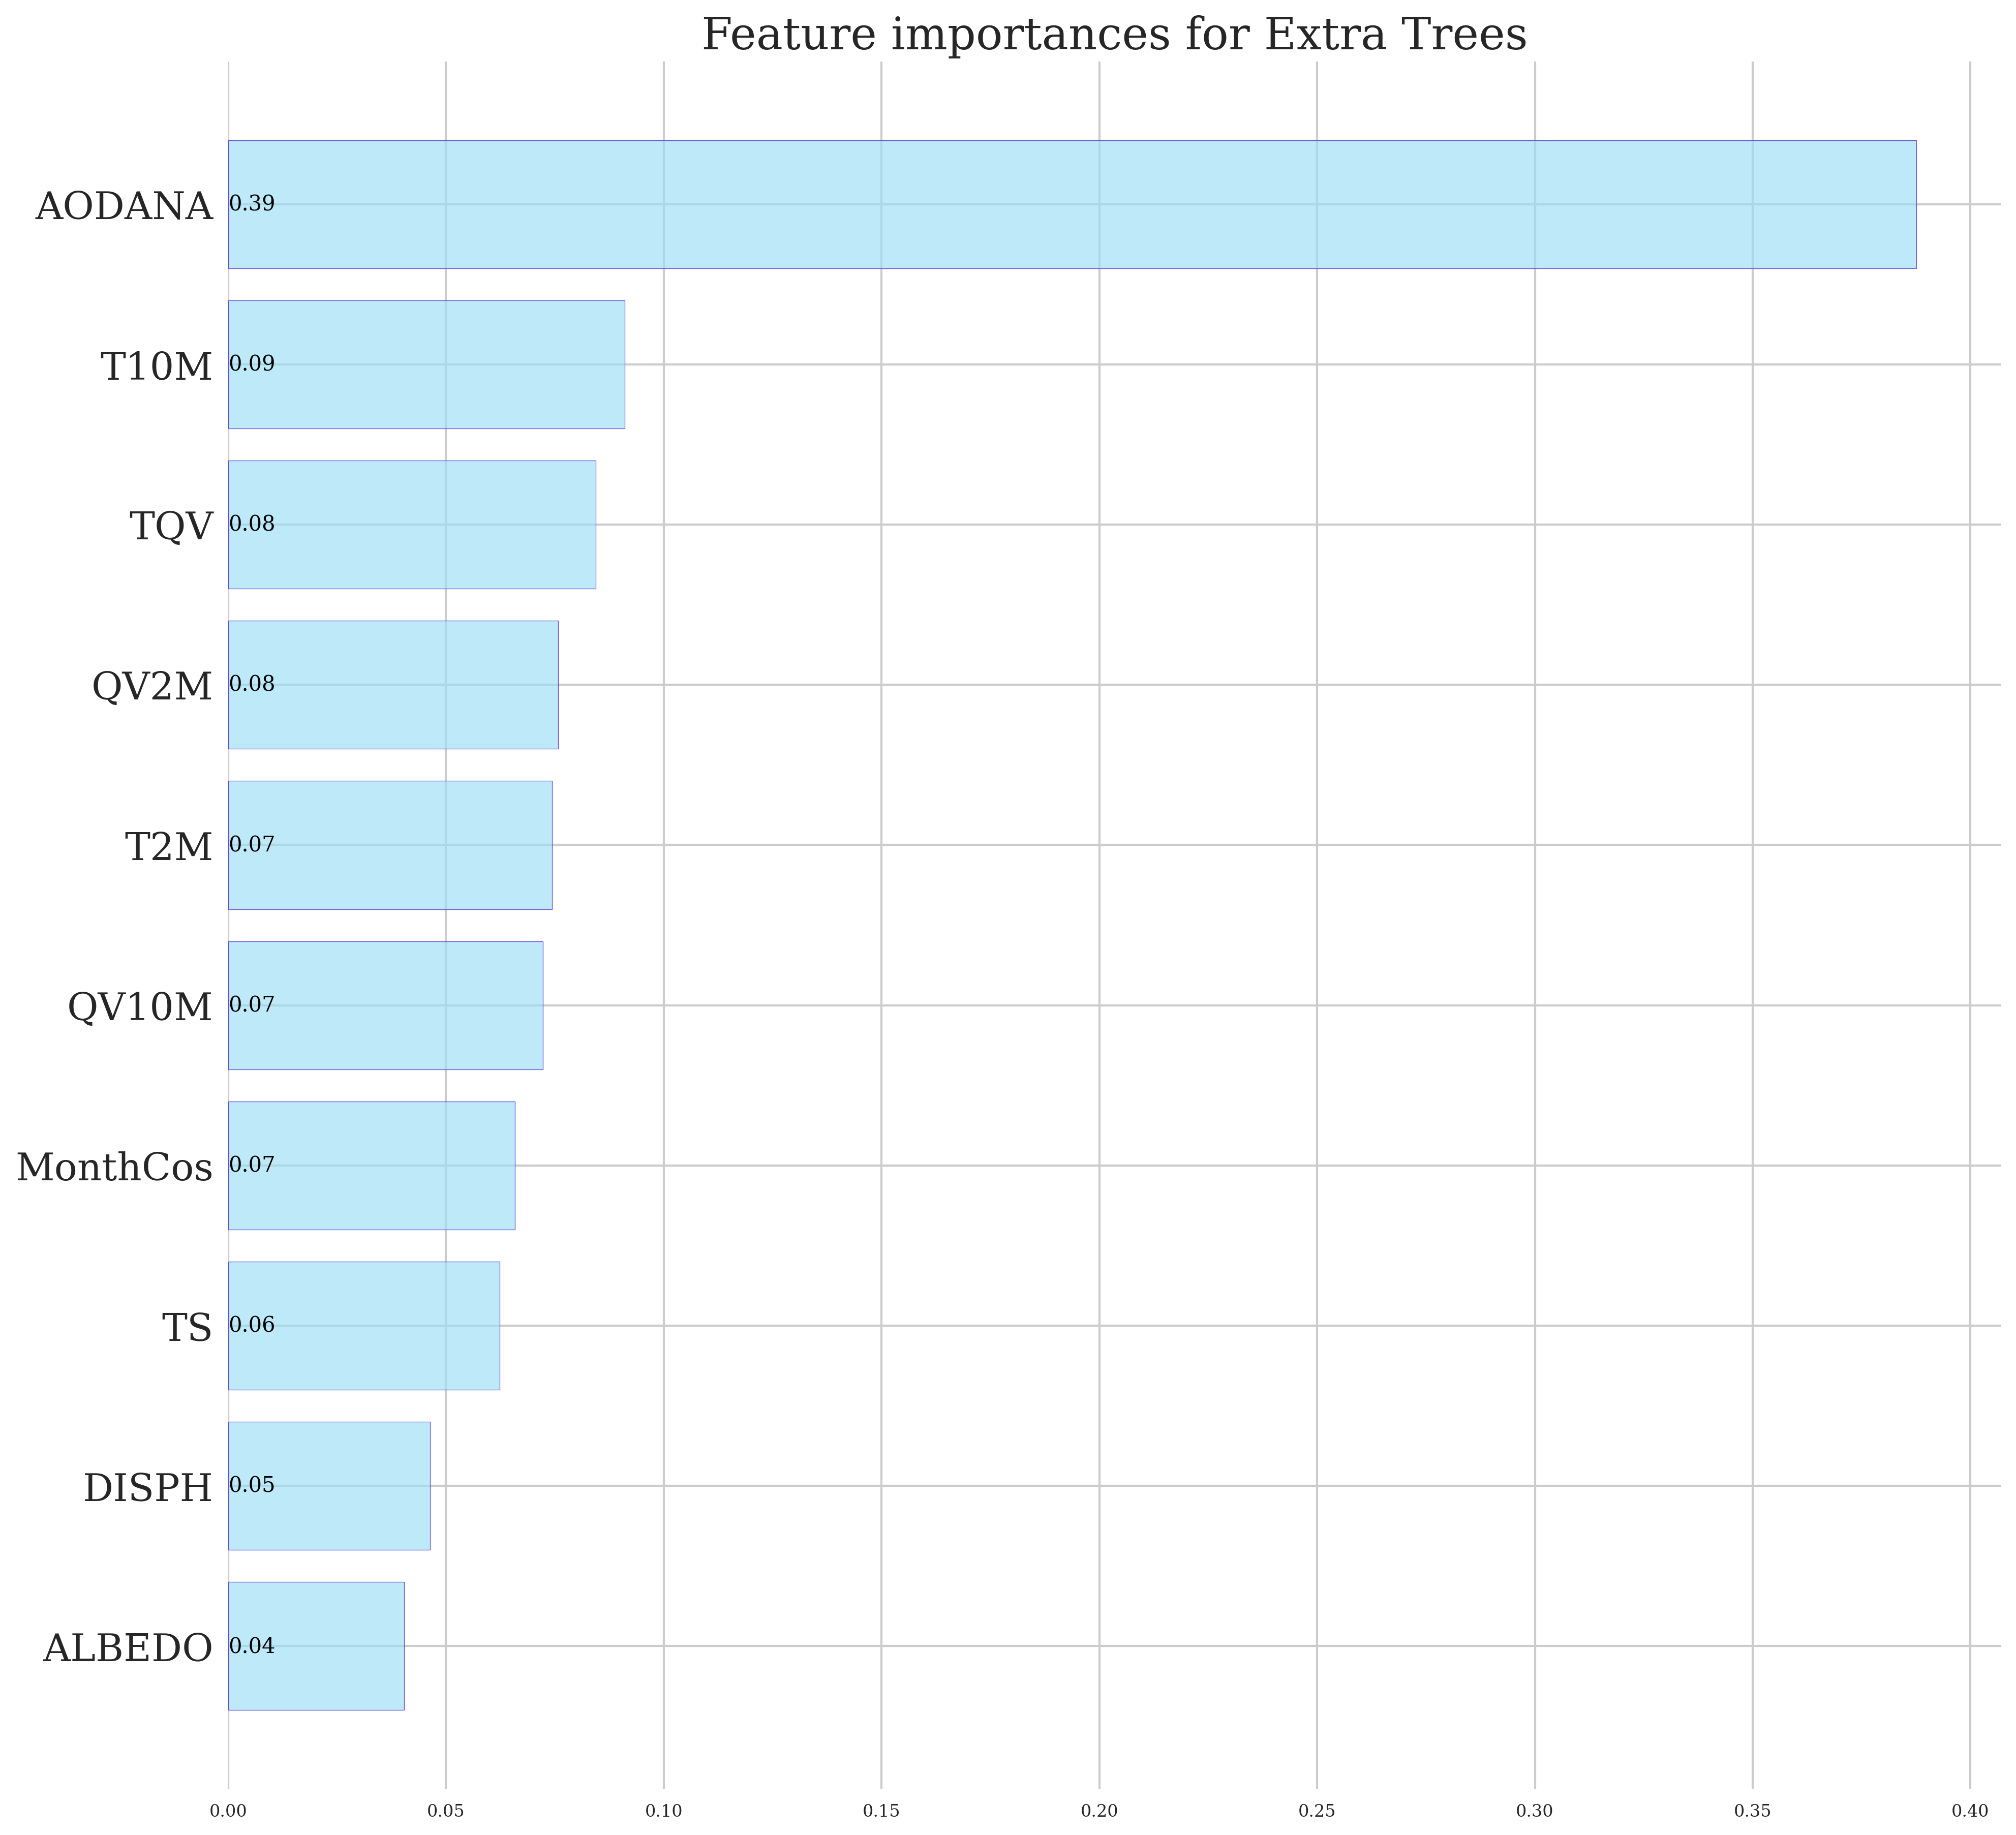

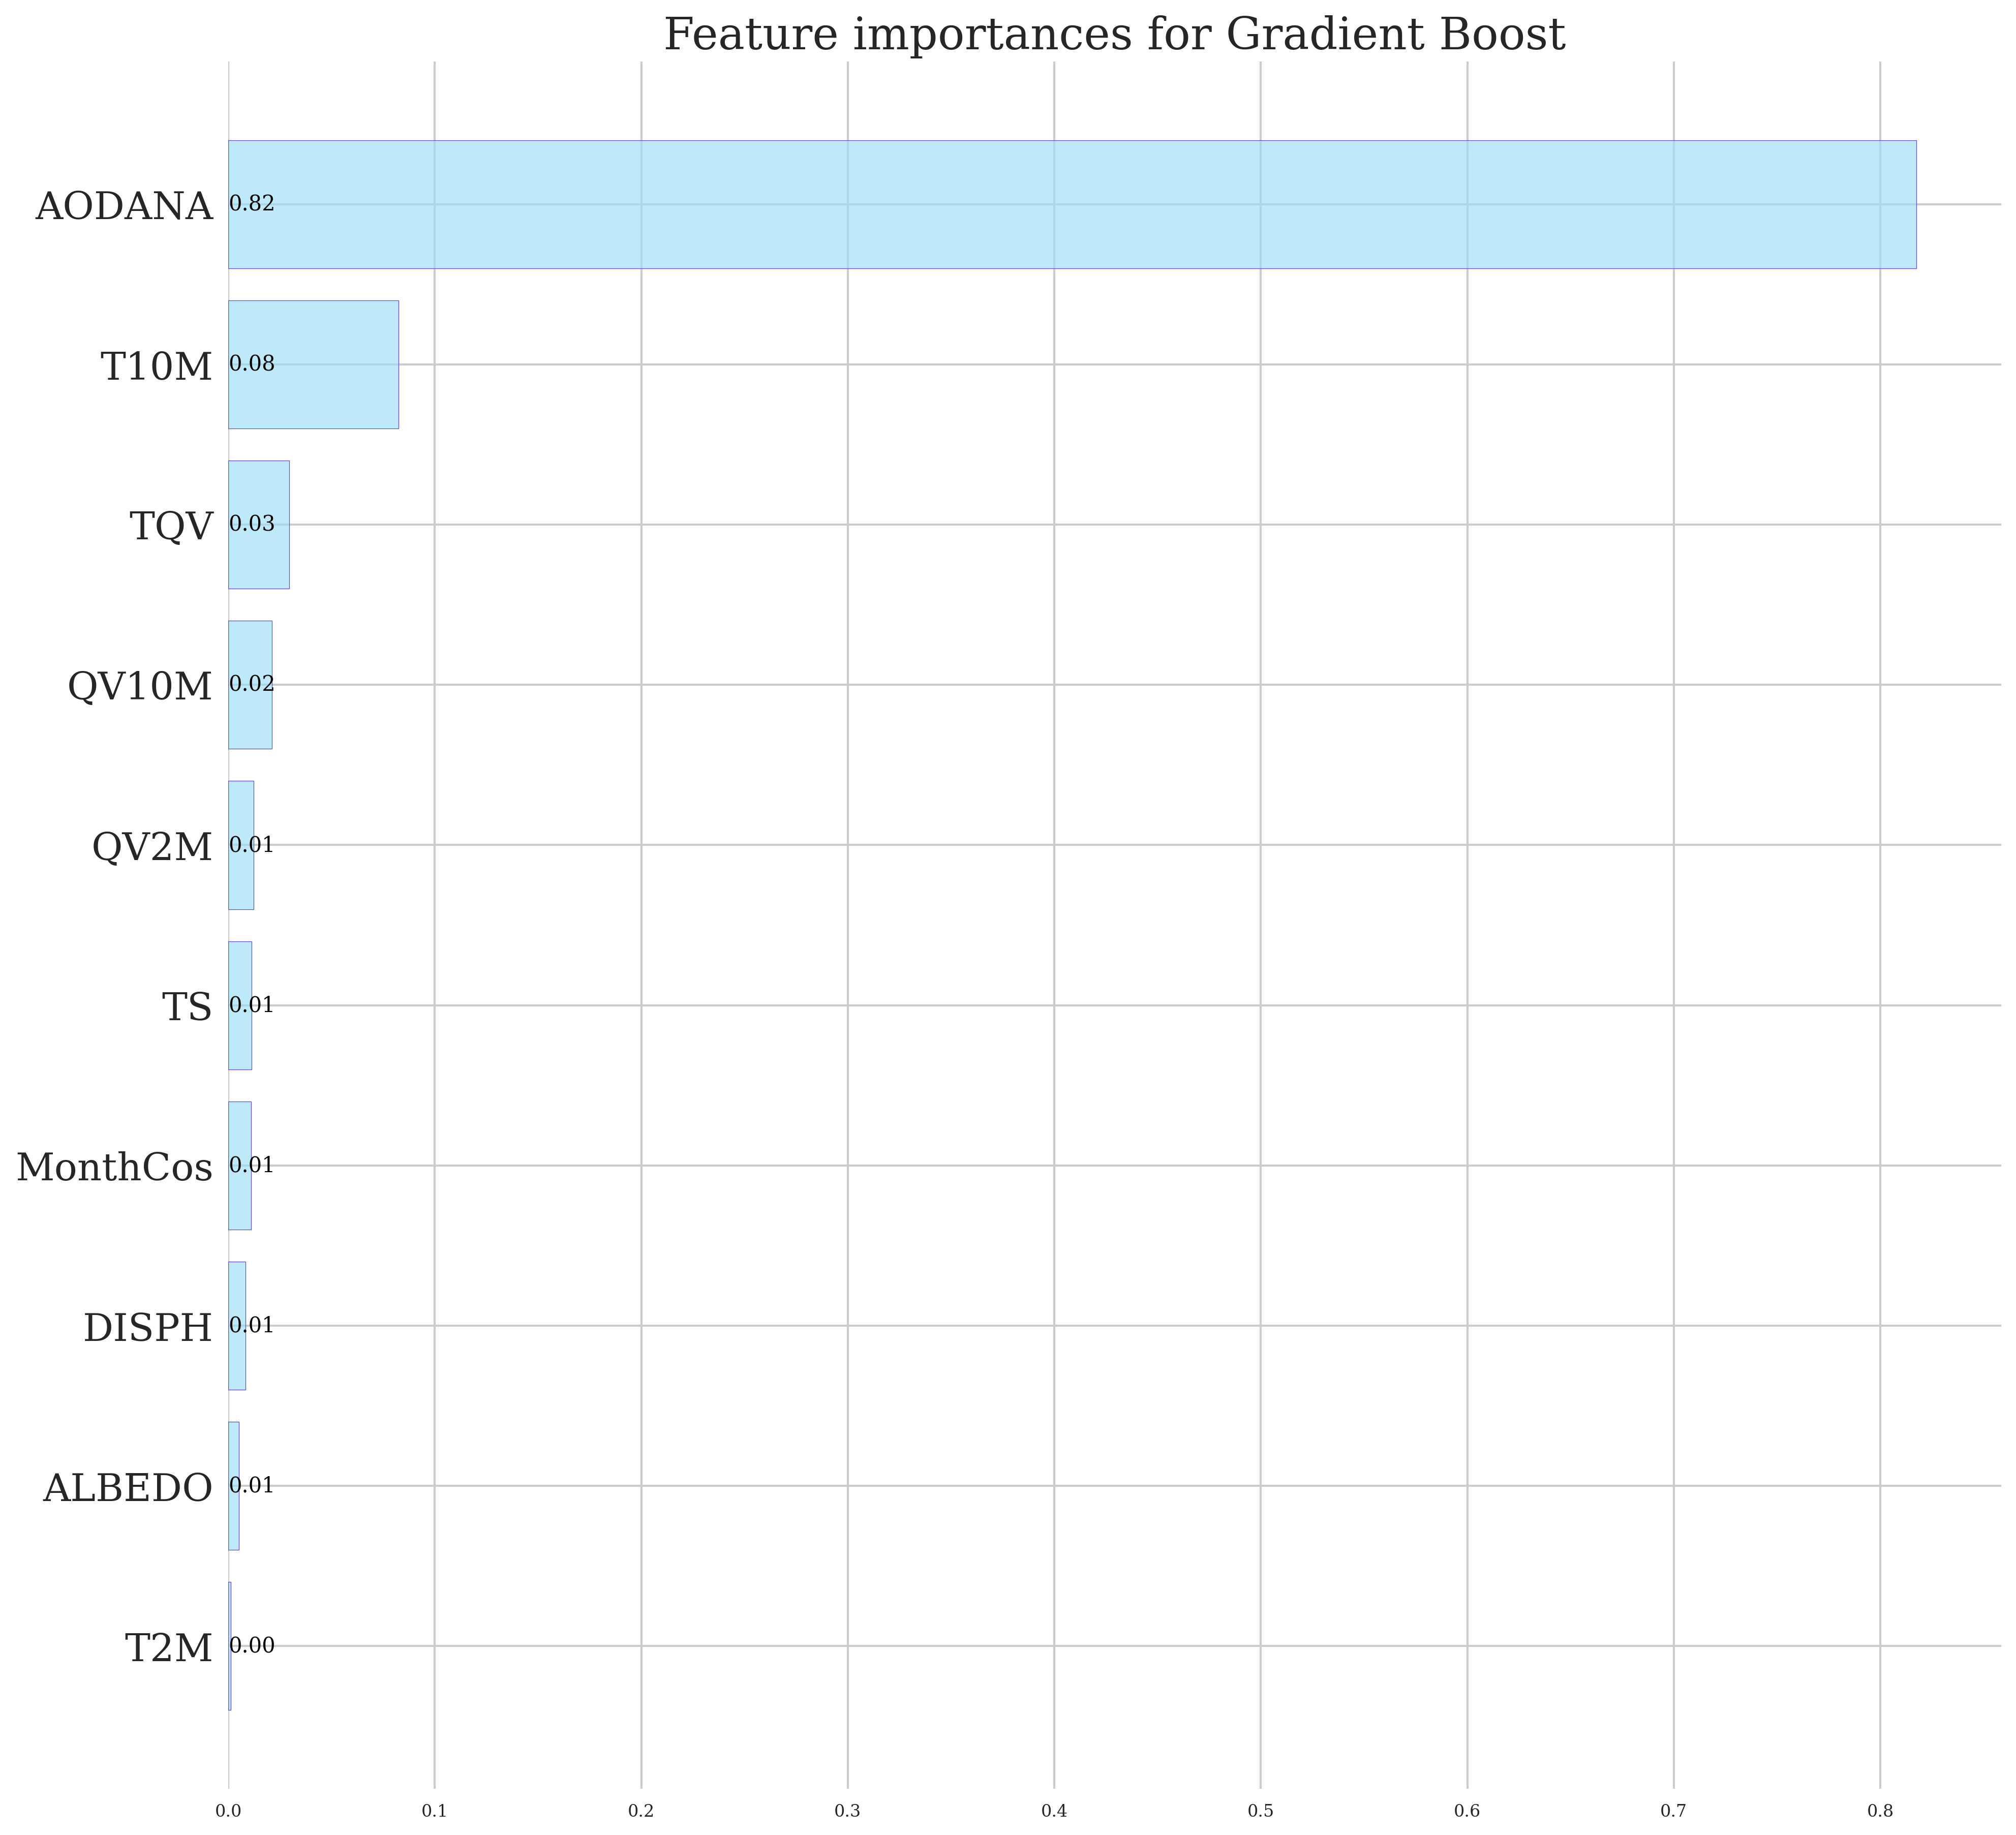

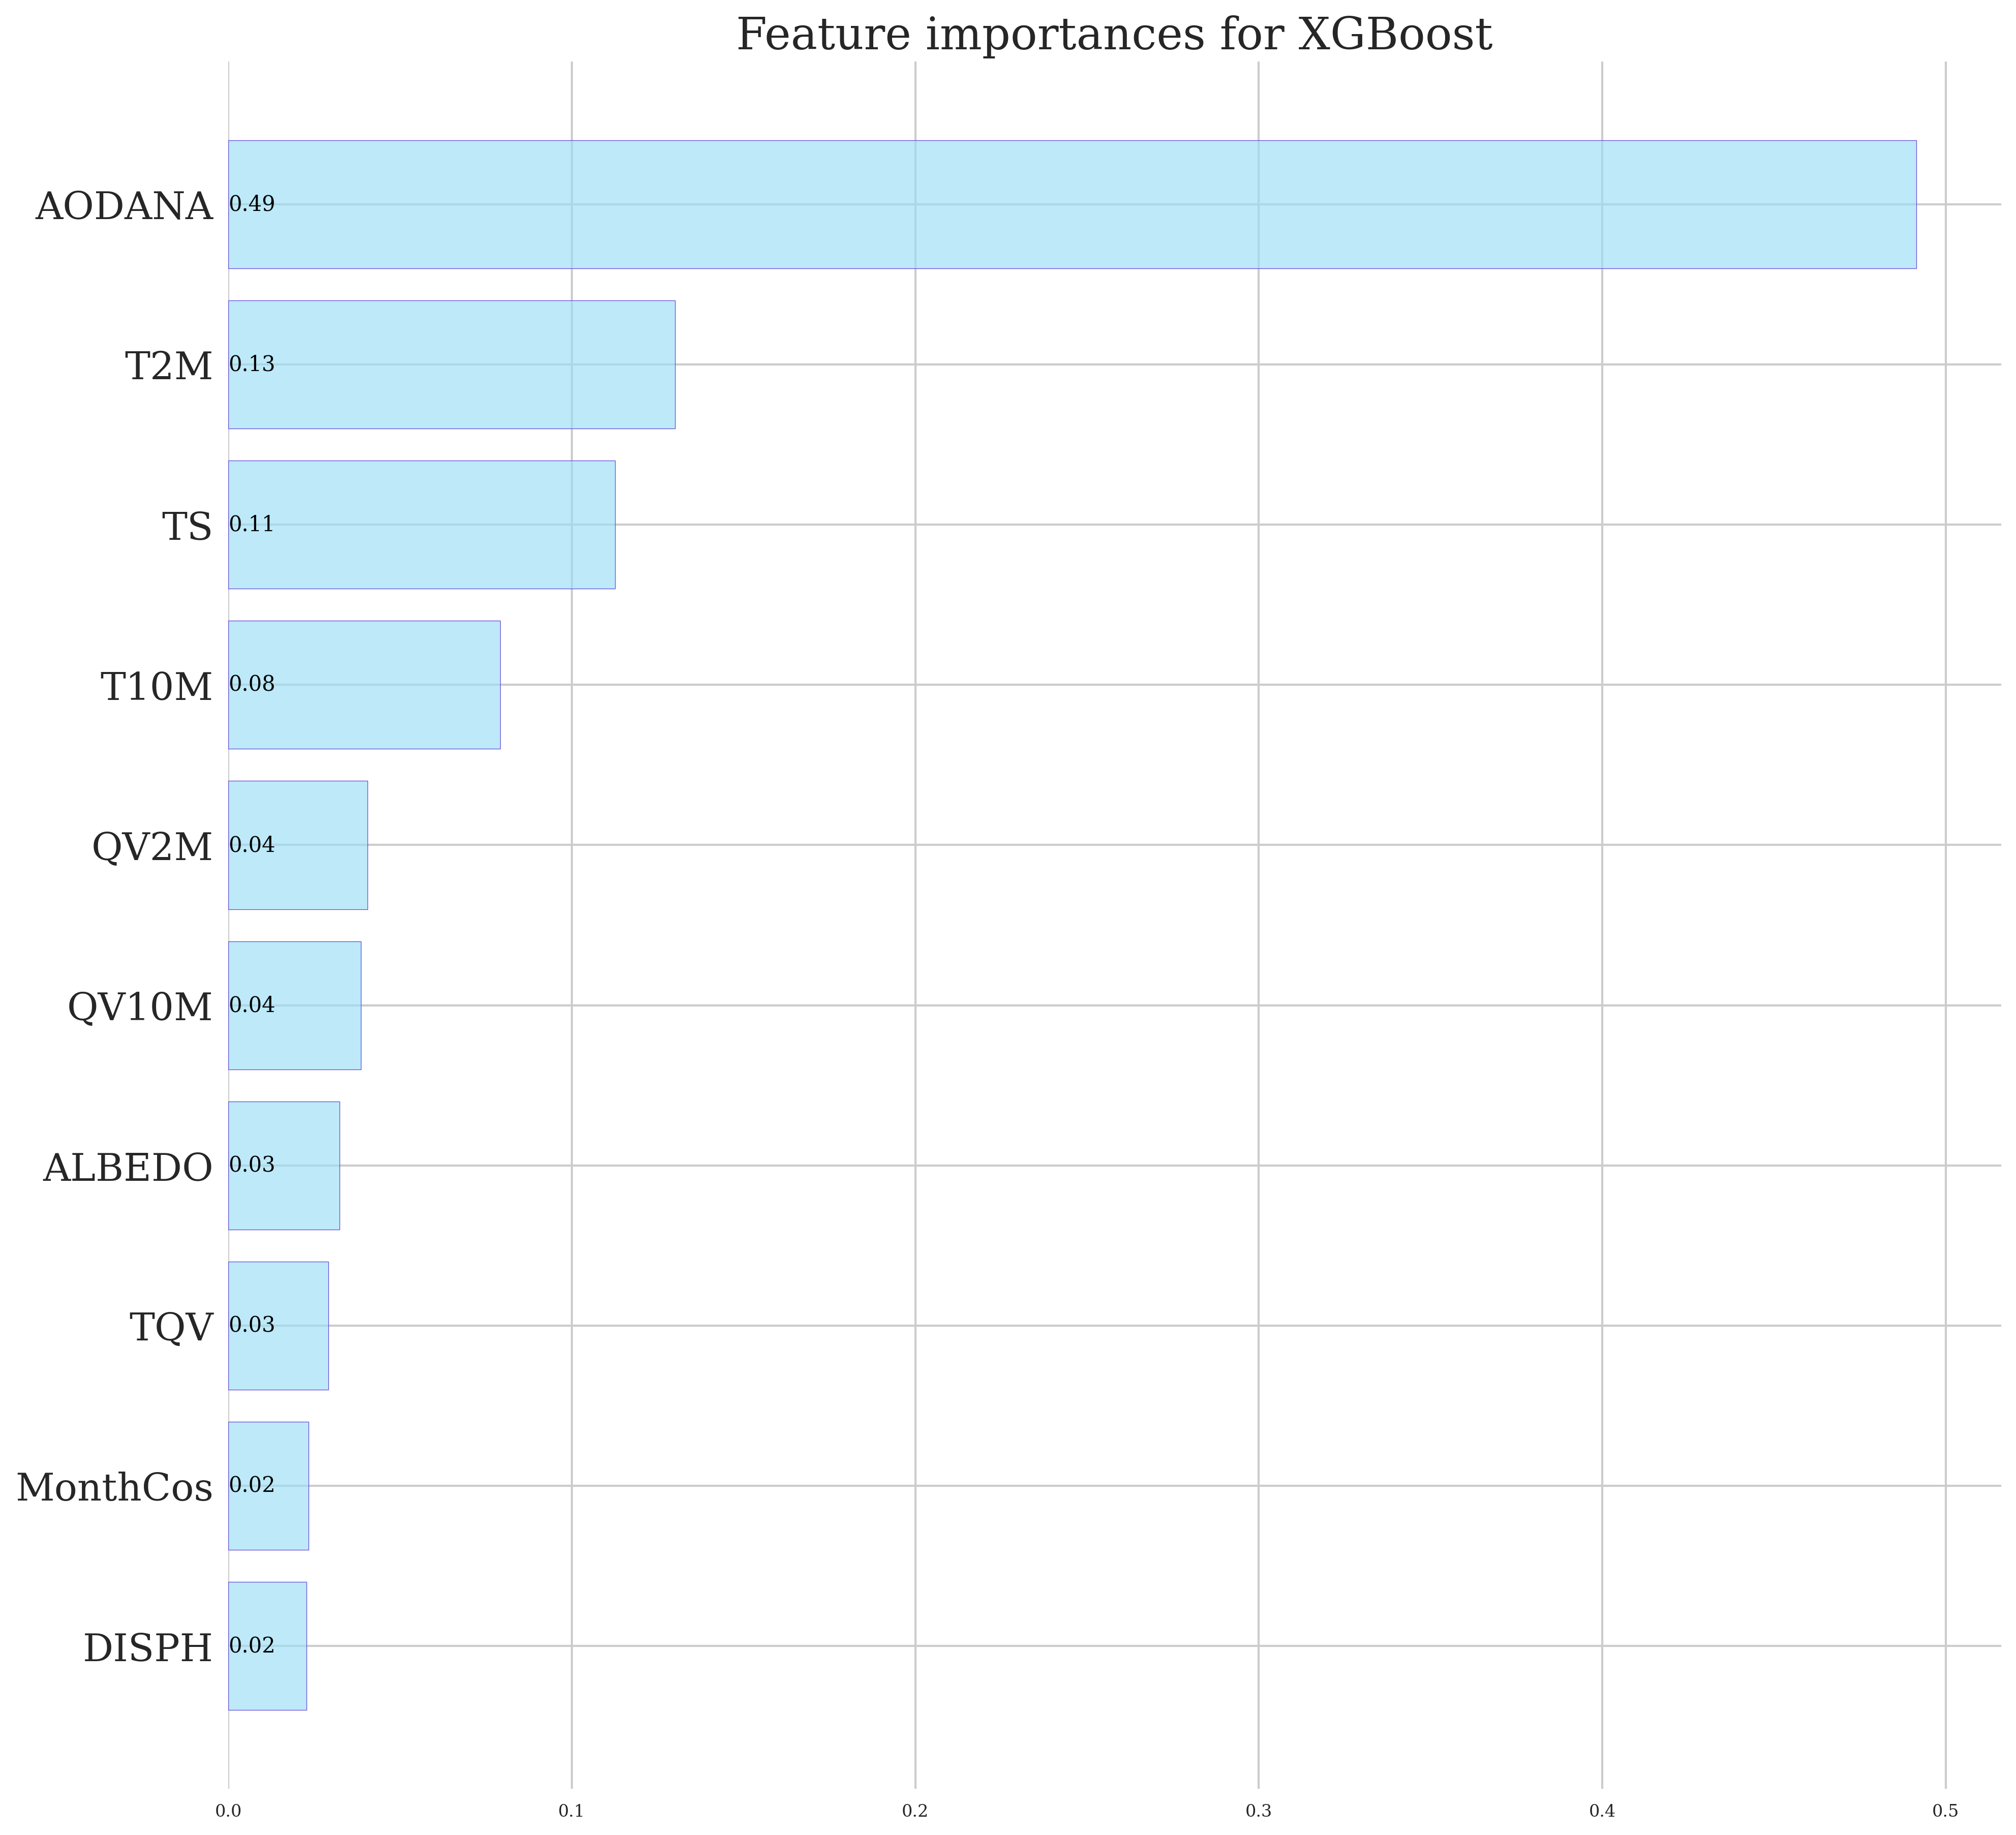

In [78]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
columns = x_train.columns.values
for name, model in mc.models.items():
    if getattr(model, 'feature_importances_', None) is not None:
        feature_importance(mc.models[name].feature_importances_, name, columns, fontsize=18)
#         plt.savefig(f'{name}-importances-log-new-features.png')

In [62]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
# for name, model in mc.models.items():
#     if getattr(model, 'coef_', None) is not None:
#         feature_importance(mc.models[name].coef_, name, columns, fontsize=18)
#         plt.savefig(f'{name}-importances-log-new-features.png')

In [63]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
# importances = mc.models['Elastic Net'].named_steps['elastic'].coef_
# feature_importance(importances, 'Elastic Net', columns, fontsize=18)
# plt.savefig(f'Elastic Net-importances-log-new-features.png')

In [64]:
# importances = mc.models['Polynomial'].named_steps['linear'].coef_
# mask = (importances > 0.1) | (importances < -0.1)
# columns = mc.models['Polynomial'].named_steps['poly'].get_feature_names(x.columns.values)
# columns = np.array([f'${c}$'.replace(" ", " \cdot ") for c in columns])
# feature_importance(importances[mask], 'Polynomial', columns[mask], fontsize=10)
# plt.savefig(f'Polynomial-importances-log-new-features.png')

# Modeling per grid cell

In [114]:
support = features.get_support()
# select lat, lon
support[0:2] = True

x_grid = train.drop('PM2.5', axis=1).loc[:, support]
y_grid = train[['PM2.5']]

train_grid = pd.concat([x_grid, y_grid], axis=1)
train_grid_2010 = train_grid.loc['2010']
train_grid_2011 = train_grid.loc['2011']

In [123]:
mcs = {}

lme_group = 'Season'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

for location, data in train_grid_2010.groupby(['lat', 'lon']):
    _x, _y = data.drop(['lat', 'lon', 'PM2.5'], axis=1), data['PM2.5']
    _mc = ModelCollection(_x.copy(), 
                          _y,
                          lme_dependent='PM', 
                          lme_formula=formula, 
                          lme_group=lme_group)
    del _mc.models['Linear Mixed Effect']
    _mc.fit()
    location = str(location)
    _mc.save(os.path.join(paths.locations, f'{location}.joblib'))
    mcs[location] = _mc

  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01726396148271192, tolerance: 0.008038195261816494
  model = cd_fast.enet_coordinate_descent_gram(


[13:48:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057837178716226845, tolerance: 0.0057347697562074
  model = cd_fast.enet_coordinate_descent_gram(


[13:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005901153245488899, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006108764671598266, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006197185425829588, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/

[13:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062032262100899516, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00644624746946576, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009336380303377467, tolerance: 0.0052822626635785986
  model = cd_fast.enet_coordinate_descent_gram(


[13:49:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055927060282851215, tolerance: 0.005975193788924244
  model = cd_fast.enet_coordinate_descent(


[13:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015336336873264855, tolerance: 0.0075703690813022995
  model = cd_fast.enet_coordinate_descent(


[13:50:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023017549495104817, tolerance: 0.00840644841363447
  model = cd_fast.enet_coordinate_descent(


[13:50:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04887490554014562, tolerance: 0.005819260233263103
  model = cd_fast.enet_coordinate_descent(


[13:50:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020902791209305605, tolerance: 0.006372111767533096
  model = cd_fast.enet_coordinate_descent(


[13:50:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024639920483863875, tolerance: 0.007622663068095334
  model = cd_fast.enet_coordinate_descent(


[13:50:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02172590341425007, tolerance: 0.007329127010882117
  model = cd_fast.enet_coordinate_descent(


[13:51:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018669928690535187, tolerance: 0.008695086228596487
  model = cd_fast.enet_coordinate_descent(


[13:51:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05802836943362166, tolerance: 0.005950910291382434
  model = cd_fast.enet_coordinate_descent(


[13:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06796865828159326, tolerance: 0.006444782363705949
  model = cd_fast.enet_coordinate_descent(


[13:51:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08463915777673847, tolerance: 0.0067863773665366054
  model = cd_fast.enet_coordinate_descent(


[13:52:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056729456844557546, tolerance: 0.007202154022040422
  model = cd_fast.enet_coordinate_descent(


[13:52:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0077271689172278, tolerance: 0.00735100601068726
  model = cd_fast.enet_coordinate_descent_gram(


[13:52:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066825058036492635, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067961412610735294, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006711043526230753, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Document

[13:52:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762043584798818, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008885599894622231, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762692899381364, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[13:52:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009936204439945584, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009886472608528152, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009658834429799867, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03992735857553242, tolerance: 0.006393267539341953
  model = cd_fast.enet_coordinate_descent(


[13:53:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0963593596983614, tolerance: 0.0068577687236111365
  model = cd_fast.enet_coordinate_descent(


[13:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009038371055154926, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009258496047337417, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009270343710760187, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:53:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007596251993113867, tolerance: 0.007439626376809449
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012622787581953787, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012499977996462519, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015947943540489007, tolerance: 0.008448997799921807
  model = cd_fast.enet_coordinate_descent(


[13:53:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01189037174562202, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011711678140279957, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01133977418727028, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[13:54:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01086406818600949, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010208006395224345, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16158593106533203, tolerance: 0.011280918527584248
  model = cd_fast.enet_coordinate_descent(


[13:54:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005486349403174273, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005860897925490605, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086242883361791, tolerance: 0.004583384953279139
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005610314428452057, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005619846402463935, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005481561529258272, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[13:54:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006542731173237115, tolerance: 0.0055192340712876525
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005935572066910311, tolerance: 0.005220210149938682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005751916264316037, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005848842005072186, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:54:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070015952872815035, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007102103464205811, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071174274812833005, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1344035875126508, tolerance: 0.006518613867154475
  model = cd_fast.enet_coordinate_descent(


[13:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007766218572122341, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007869532161919324, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007871735710146766, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009089472088710693, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012177398179240129, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01367479626131285, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00982970969522512, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010071865137319946, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010047952062528509, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

[13:55:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011062220284706825, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011319376392656011, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009745064280458848, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01218713141815897, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01650640823489624, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016984683336694673, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[13:55:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011859437916200477, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739233235118718, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011496017551564819, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013697859122345335, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013473062975506878, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013070163052304906, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01714496998959092, tolerance: 0.005239026523052261
  model = cd_fast.enet_coordinate_descent(


[13:55:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04618886321344107, tolerance: 0.00502269523580531
  model = cd_fast.enet_coordinate_descent(


[13:56:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04771040410876992, tolerance: 0.005249487596680164
  model = cd_fast.enet_coordinate_descent(


[13:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07114754029865722, tolerance: 0.005557820784922568
  model = cd_fast.enet_coordinate_descent(


[13:56:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006089805343446386, tolerance: 0.005286688513649417
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005662814306568009, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00612532503307861, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34842143755779986, tolerance: 0.00603709134964059
  model = cd_fast.enet_coordinate_descent(


[13:56:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006730377817106614, tolerance: 0.005025904687024401
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005206496789572412, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005313797832368294, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5304287914978509, tolerance: 0.005863364642332474
  model = cd_fast.enet_coordinate_descent(


[13:56:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005229722247428015, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005409807883669515, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055217202639212815, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:56:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030936819919553216, tolerance: 0.006347314147745285
  model = cd_fast.enet_coordinate_descent(


[13:56:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007549126692907748, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007681208783154148, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010349183614302149, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008575914576908872, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00948093765083513, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010405493573884428, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010818217961045207, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011246208391888501, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011360278102920063, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008912067934637946, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014026402962102225, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014429913457476573, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010145308382362828, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011254740291931853, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016121504292677002, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015509453001499196, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019140848147230827, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019931187791499383, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011499366109841702, tolerance: 0.006451367818988432
  model = cd_fast.enet_coordinate_descent(


[13:57:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00969325370930818, tolerance: 0.006331524543675675
  model = cd_fast.enet_coordinate_descent(


[13:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005865285482265392, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061204465084330195, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006285136664715196, tolerance: 0.005940331123284464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007941419607917055, tolerance: 0.005240912577860033
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00590839838964996, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006375555418017598, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005447321497872082, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055007068747201515, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005505223918639501, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005570640804581473, tolerance: 0.005245908160673422
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049845103213542075, tolerance: 0.005631886366156586
  model = cd_fast.enet_coordinate_descent(


[13:58:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006279606126177839, tolerance: 0.005201873606065792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005225592926901612, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00561827738449594, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[13:58:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005565256289294496, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057386137467041465, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005846859579005326, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006716826547048527, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006645481491283078, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006504487143601523, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20842944020434473, tolerance: 0.0068588829073802406
  model = cd_fast.enet_coordinate_descent(


[13:58:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007145567622103499, tolerance: 0.006514233279643029
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007932102636399208, tolerance: 0.006554226333080977
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015442076378896274, tolerance: 0.007314992904614687
  model = cd_fast.enet_coordinate_descent_gram(


[13:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011056360985712388, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739716723475624, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012090465194503963, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008947629358722509, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009951829902483667, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011001611715862225, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010193502689133993, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012434957882447861, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012523660201679832, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:59:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071997760873863115, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072373925951225715, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(


[13:59:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006724277350404151, tolerance: 0.005927976158490512
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006074853522473944, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006342429577884445, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071420375560506955, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007263864518321839, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007306927987393408, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063443172839754425, tolerance: 0.00527597511480843
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006414403792906143, tolerance: 0.0053905043508186016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068051469791825525, tolerance: 0.005421673810839912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060069712759514005, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006000034115874797, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005963126955037978, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006019187328902831, tolerance: 0.005313353662490148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006859276304645334, tolerance: 0.005507918937292674
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00557056046393356, tolerance: 0.005476043115595099
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006051208630239557, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059887653968857535, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005894715844078746, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:59:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057472407045981555, tolerance: 0.0067443857175496875
  model = cd_fast.enet_coordinate_descent(


[14:00:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15701658792549011, tolerance: 0.007047751022005929
  model = cd_fast.enet_coordinate_descent(


[14:00:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01063016986324783, tolerance: 0.008579997955138053
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007822331969670415, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008109087016130445, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013340060033279144, tolerance: 0.00808798810430039
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014282920264292898, tolerance: 0.00808798810430039
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007724841554100692, tolerance: 0.007413395104548366
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:00:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009962303397074379, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012986276731702162, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014558587790794775, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012903352398836887, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012820485357480038, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012688382369780982, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012422799122703054, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012268208779090628, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012017742151556376, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076965466758878165, tolerance: 0.00737067658143229
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008062998073331329, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008323776913698566, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006444579923886806, tolerance: 0.006270061335615926
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007001616328331295, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007395532802703997, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008884930123734591, tolerance: 0.006947142960585666
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007255024008060218, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007599039325555168, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:01:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006035508156198688, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008494880783985082, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008939376230852503, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007456781078289509, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007590524582482772, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074276449513313025, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[14:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006518203628761654, tolerance: 0.005890762465802838
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005943795682675557, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063776489230384925, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(


[14:01:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011213600098720633, tolerance: 0.006445229888146498
  model = cd_fast.enet_coordinate_descent_gram(


[14:01:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:01:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076527904917824685, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007670950957447076, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007531679342910991, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23542755350277034, tolerance: 0.007474601612041126
  model = cd_fast.enet_coordinate_descent(


[14:01:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009193276999539535, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009407604833846506, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009425786130790925, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[14:02:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011726553704740184, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014067911974571246, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011680718321557038, tolerance: 0.00799337866729679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[14:02:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012128592084138745, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017550084536445354, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016871076983939304, tolerance: 0.009307549536093836
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05836743905522468, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018241596662058157, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019769892789227583, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:02:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020106848493639973, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020330669414960312, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019969395045812632, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:02:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010678718589673508, tolerance: 0.008592900228304598
  model = cd_fast.enet_coordinate_descent(


[14:02:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01046806734107264, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011790722174339408, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012030182544336299, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:02:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013743598582315997, tolerance: 0.006970046111822598
  model = cd_fast.enet_coordinate_descent_gram(


[14:03:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008079381285856613, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008027346659929435, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007903571544169097, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:03:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010973661585310879, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01452583701222565, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015289680060096345, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:03:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009312747911927488, tolerance: 0.00798483946954334
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009649267151317531, tolerance: 0.00814376239395955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013149633471854827, tolerance: 0.008708396352998131
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:03:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00921685034730757, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010321833539450154, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009805418221993989, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030469433047286998, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014246243416060622, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024232206992891747, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:03:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01205138859462096, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019191689795277966, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021667272718097763, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014598434138363814, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022266980991197727, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02306847245814936, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6180014555795594, tolerance: 0.01179113175878902
  model = cd_fast.enet_coordinate_descent(


[14:03:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [140]:
import glob

mcs = {}

for file in glob.glob(os.path.join(paths.locations, '*')):
    _file_name = os.path.basename(file)
    _location = os.path.splitext(_file_name)[0]
    _mc = ModelCollection.__new__(ModelCollection)
    _mc.load(file)
    mcs[_location] = _mc

[15:26:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [143]:
mcs[_location].scaler.mean_

array([ 8.77907814e-03,  8.57824184e-03,  2.90787170e+02,  2.90877083e+02,
        2.24476397e+01, -2.14529047e+00,  1.82171736e-01,  2.91299096e+02,
       -2.37267234e-03,  2.39632788e-01])

In [263]:
grid_predictions = None
grid_scores = None

for location, data in train_grid_2011.groupby(['lat', 'lon']):
    _mc = mcs[str(location)]
    
    _x = data.copy()
    _x = _x.drop(['lat', 'lon', 'PM2.5'], axis=1)
    
    _predictions = _mc.predict(_x)
    _predictions = pd.DataFrame(_predictions, index=data.index)
    _predictions['True Value'] = data['PM2.5']
    
    _scores = scores_from_model_collection_predictions(_predictions).reset_index()
    _scores['lat'] = pd.Series([location[0] for i in range(len(_scores.index))], index=_scores.index)
    _scores['lon'] = pd.Series([location[1] for i in range(len(_scores.index))], index=_scores.index)
    
    _predictions['lat'] = pd.Series([location[0] for i in range(len(data.index))], index=data.index)
    _predictions['lon'] = pd.Series([location[1] for i in range(len(data.index))], index=data.index)
    
    if grid_predictions is None:
        grid_predictions = _predictions
        grid_scores = _scores
        
    else:
        grid_predictions = pd.concat([grid_predictions, _predictions])
        grid_scores = pd.concat([grid_scores, _scores])

In [203]:
grid_predictions = grid_predictions.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()
grid_predictions_file = os.path.join(paths.locations, '2011_predictions.nc4')
grid_predictions.to_netcdf(grid_predictions_file)

In [69]:
grid_scores_file = os.path.join(paths.locations, '2011_scores.csv')

In [272]:
grid_scores.to_csv(grid_scores_file)

In [71]:
grid_scores = pd.read_csv(grid_scores_file)

In [73]:
grid_scores

Unnamed: 0           Model   R2  MAE  RMSE   lat     lon
0              0       Ada Boost 0.60 0.25  0.31 26.00  -97.50
1              1  Bayesian Ridge 0.67 0.22  0.29 26.00  -97.50
2              2     Elastic Net 0.67 0.22  0.29 26.00  -97.50
3              3     Extra Trees 0.68 0.22  0.28 26.00  -97.50
4              4  Gradient Boost 0.67 0.22  0.29 26.00  -97.50
...          ...             ...  ...  ...   ...   ...     ...
2893           9            MLP3 0.48 0.32  0.40 36.50 -102.50
2894          10      Polynomial 0.44 0.32  0.42 36.50 -102.50
2895          11   Random Forest 0.60 0.28  0.35 36.50 -102.50
2896          12             SVR 0.68 0.25  0.32 36.50 -102.50
2897          13         XGBoost 0.58 0.29  0.36 36.50 -102.50

[2898 rows x 7 columns]

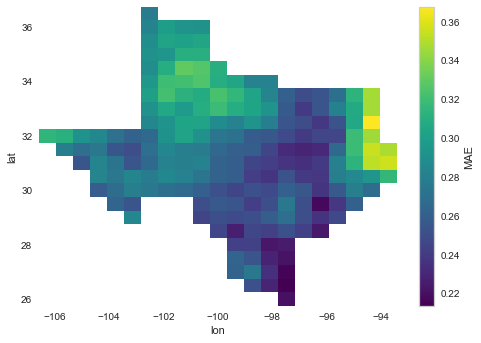

In [72]:
filt = grid_scores['Model'] == 'Random Forest'
grid_scores[filt].set_index(['lat', 'lon']).drop(['Model'], axis=1).to_xarray()['MAE'].plot()

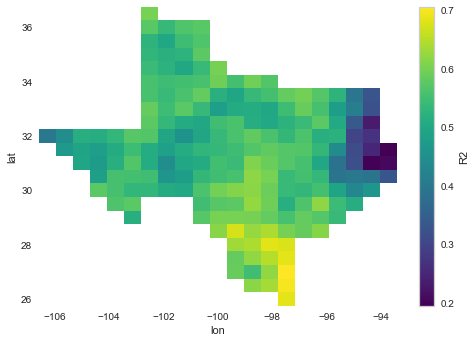

In [285]:
grid_scores[filt].set_index(['lat', 'lon']).drop(['Model'], axis=1).to_xarray()['R2'].plot()

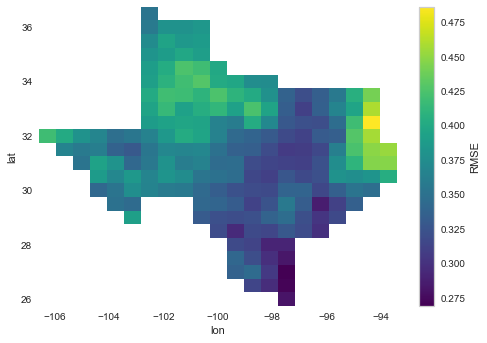

In [284]:
grid_scores[filt].set_index(['lat', 'lon']).drop(['Model'], axis=1).to_xarray()['RMSE'].plot()

# Publication Figures

## Tables and Statistics

In [51]:
order = ['Linear Regression', 'Elastic Net', 'Polynomial', 'Bayesian Ridge', 'SVR', \
         'Ada Boost', 'Random Forest','Extra Trees', 'Gradient Boost', 'XGBoost', \
         'MLP', 'MLP1', 'MLP2', 'MLP3', 'MLP4', 'MLP5', 'True Value']

linear = ["Linear Regression", "Elastic Net", "Polynomial", "Bayesian Ridge", "SVR"]
trees = ["Ada Boost", "Random Forest", "Extra Trees", "Gradient Boost", "XGBoost"]
nn = ["MLP", "MLP1", "MLP2", "MLP3", "MLP4", "MLP5"]

nn_color = "#FCA481"
tree_color = "#6549DA"
linear_color = "#6CB0F2"

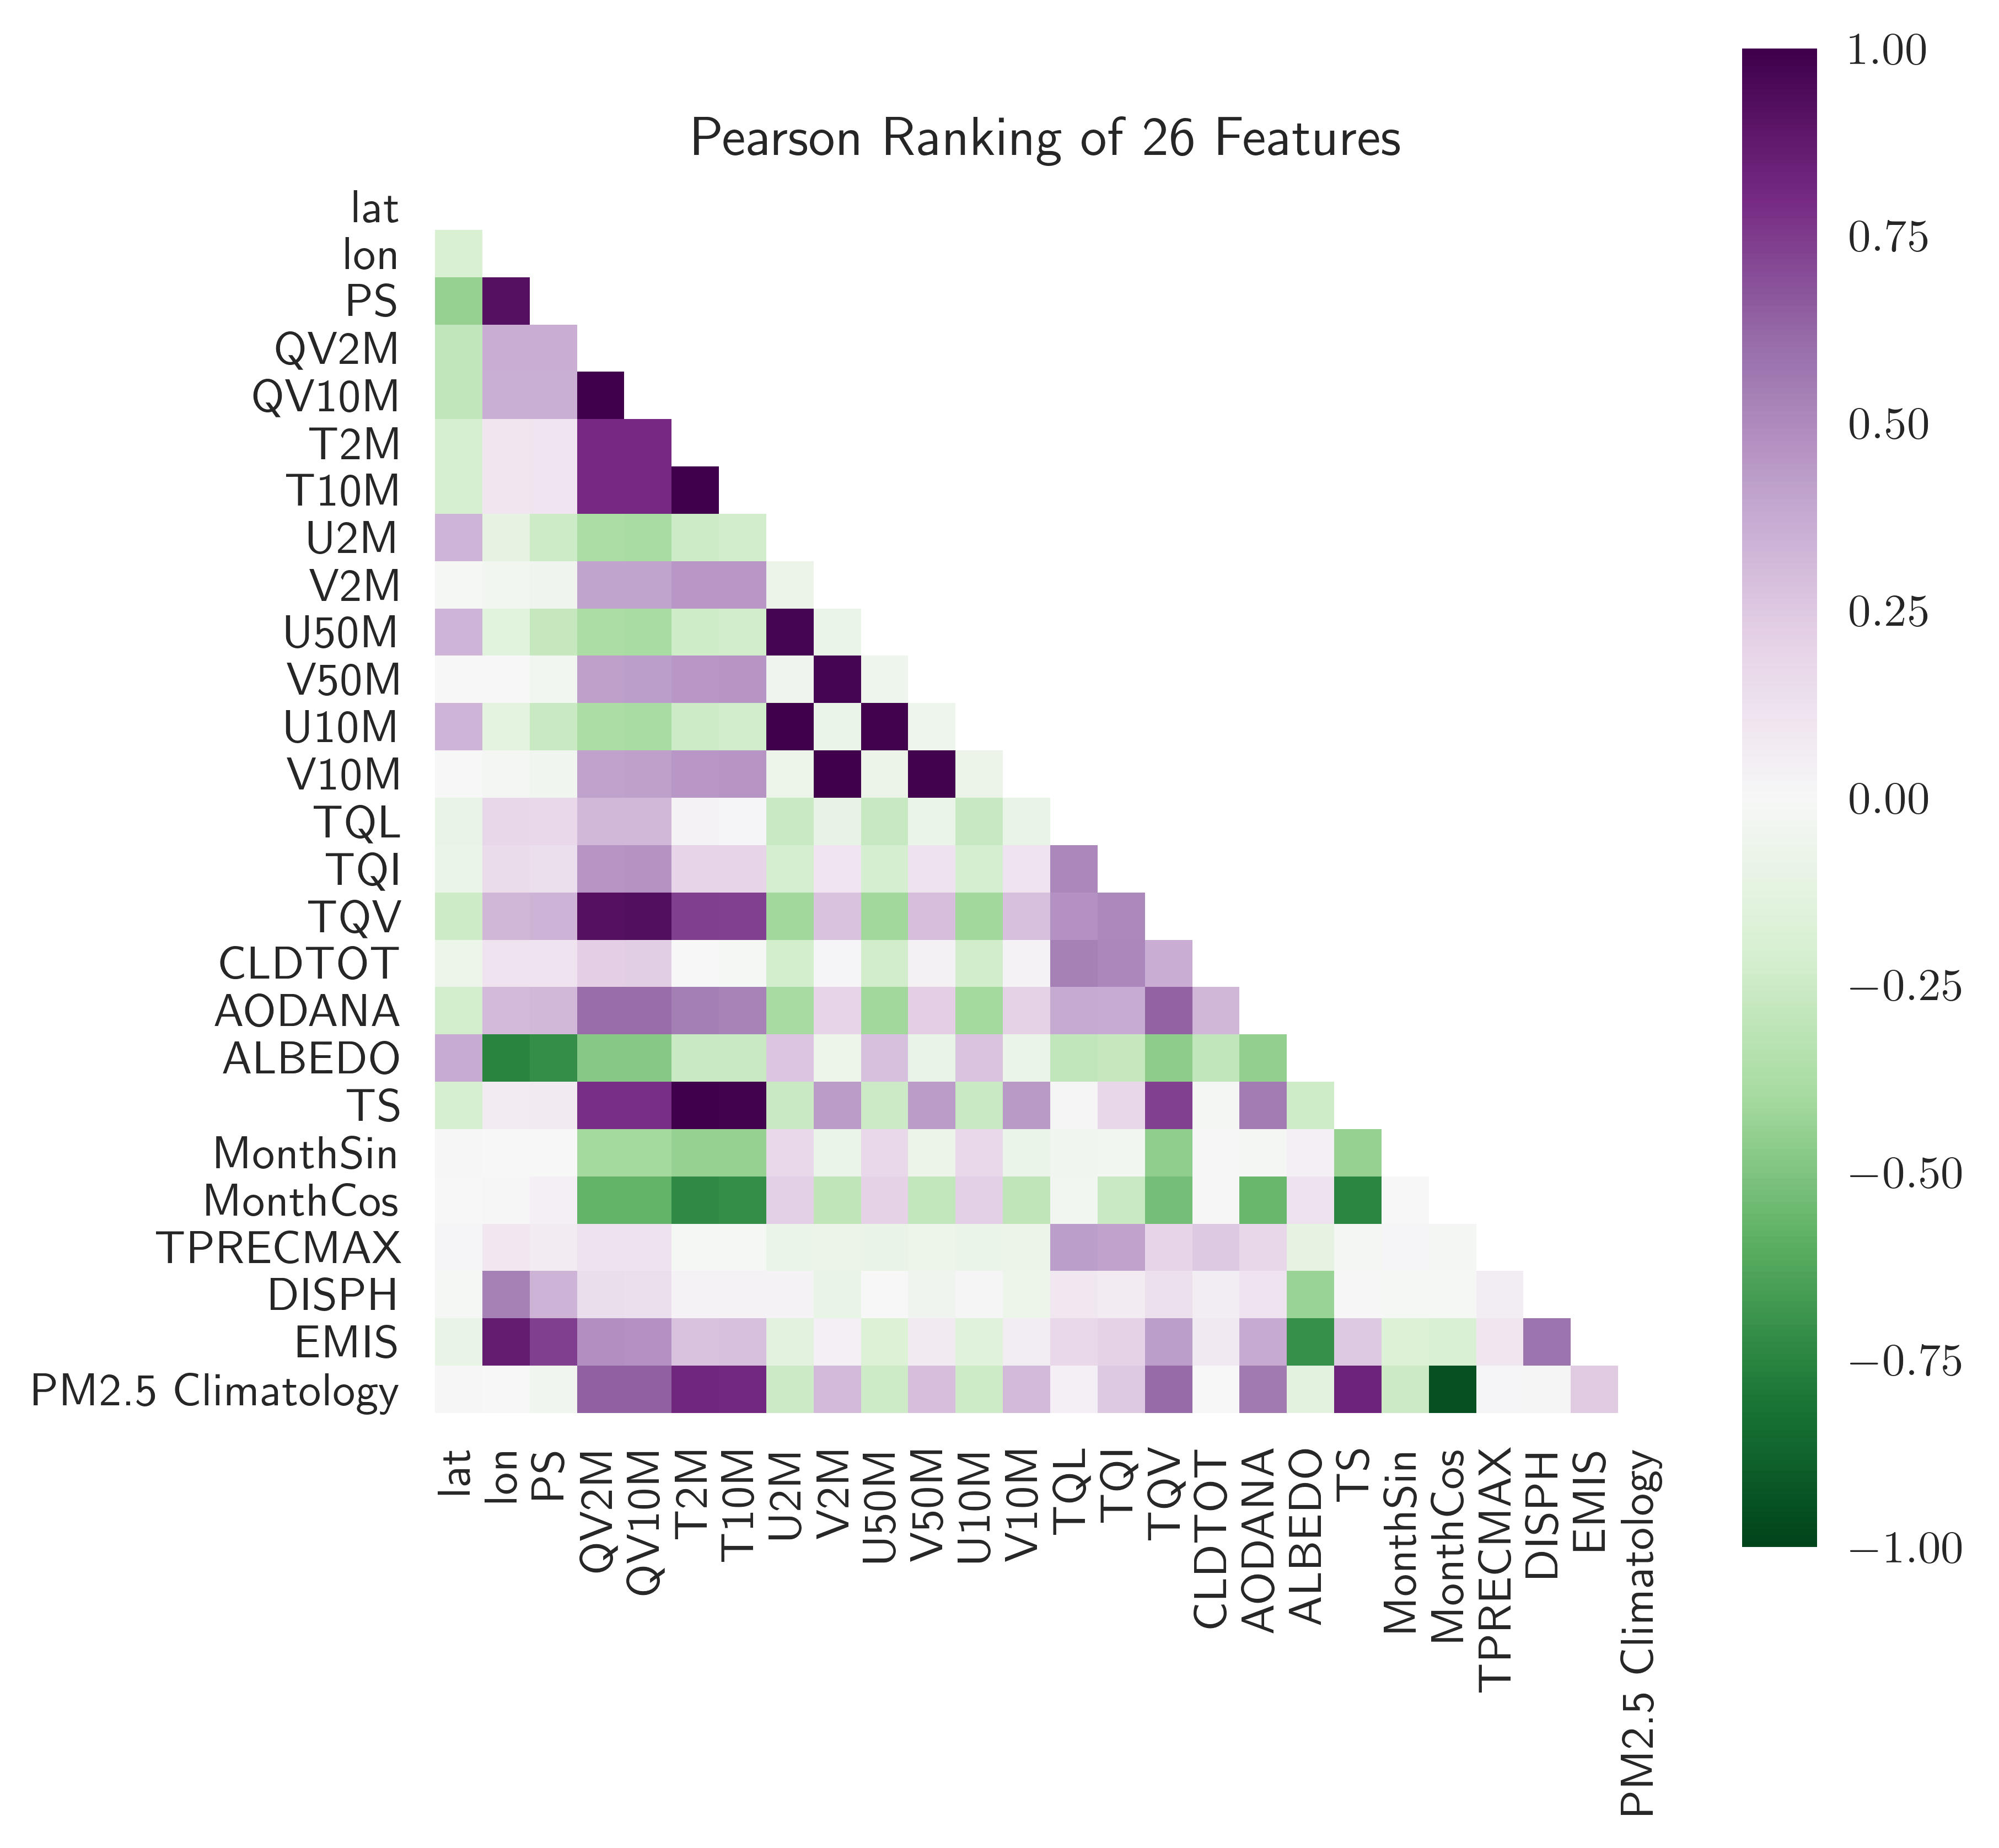

In [52]:
# x, y = train.drop('PM2.5', axis=1), train['PM2.5']
from yellowbrick.features import Rank2D

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

no_pm = train.drop('PM2.5', axis=1)
visualizer = Rank2D(algorithm='pearson', ax=ax, colormap='PRGn_r')
visualizer.fit(no_pm)
visualizer.transform(no_pm)

ax.tick_params(axis='both', which='major')


visualizer.show();

fig.savefig(os.path.join(paths.figures, 'pearson-ranking.png'))

In [53]:
pd.set_option('display.float_format', '{:.6g}'.format)

mean_s = train.mean()
std_s = train.std()
stats = pd.DataFrame({'mean': mean_s, 'std': std_s}).reindex(['AODANA' ,'QV10M' ,'T2M' ,'TS' ,'QV2M' ,'T10M' ,'TQV' ,'MonthCos' ,'ALBEDO' ,'DISPH' ,'EMIS' ,'TPRECMAX' ,'PS' ,'lon' ,'lat' ,'V2M' ,'V50M' ,'V10M' ,'TQI' ,'U50M' ,'U2M' ,'U10M' ,'TQL' ,'MonthSin' ,'CLDTOT'])
print(stats.to_csv())

,mean,std
AODANA,-2.0540032386779785,0.6249045729637146
QV10M,0.009137289598584175,0.004780693911015987
T2M,292.45648193359375,8.931633949279785
TS,293.127685546875,9.397623062133789
QV2M,0.009330807253718376,0.00483490526676178
T10M,292.5204162597656,8.721508026123047
TQV,23.912080764770508,13.49736213684082
MonthCos,-0.0020288169850361526,0.7084341790668174
ALBEDO,0.18288332223892212,0.030684031546115875
DISPH,0.9499621987342834,2.2911453247070312
EMIS,0.9747610688209534,0.00990260299295187
TPRECMAX,0.00013201983529143035,0.0005254609859548509
PS,95903.71875,4639.49853515625
lon,-99.30555555555556,2.883628791825722
lat,31.352657004830917,2.1420086388833757
V2M,0.8842414617538452,2.2475740909576416
V50M,2.0188241004943848,4.506814479827881
V10M,1.323911428451538,3.227409839630127
TQI,0.022686846554279327,0.039259783923625946
U50M,-0.4506705403327942,3.2526330947875977
U2M,-0.23139998316764832,1.5836460590362549
U10M,-0.3444986045360565,2.273599624633789
TQL,0.03026585280895233,0.04707

In [54]:
idx = np.argsort(features.scores_)[::-1]
mi_scores = pd.DataFrame({'Features': train.drop('PM2.5', axis=1).columns.values[idx], 'Scores': features.scores_[idx]})
print(mi_scores.to_csv(index=False))

Features,Scores
AODANA,0.40697520664956777
QV10M,0.18270261535033505
T2M,0.18255441544121265
TS,0.1812740105566073
QV2M,0.18080713099685397
T10M,0.17936926316851753
TQV,0.16578542912411987
PM2.5 Climatology,0.15295923522699217
MonthCos,0.13989409228297411
ALBEDO,0.0884673913396945
DISPH,0.07616628573041684
EMIS,0.07500156095570887
TPRECMAX,0.06872525471184598
PS,0.06413500764092817
lon,0.05807892176971263
lat,0.054498066995910754
V2M,0.05205044676974868
V50M,0.04925580177294364
V10M,0.04856884670632855
TQI,0.04424595378057283
U50M,0.040058321911878636
U2M,0.038350809405695685
U10M,0.03828481896019831
TQL,0.031644156184910344
MonthSin,0.030865700463922785
CLDTOT,0.01635216027087605



In [55]:
from utils import summarize_scores

In [56]:
# labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
models = []
r2s = []
maes = []
rmses = []

for model_name, score in mc.cross_val_scores_.items():
    r2, mae, rmse = summarize_scores(score)
    models.append(model_name)
    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

cv_results = pd.DataFrame({'Model': models, 'R2': r2s, 'MAE': maes, 'RMSE': rmses}).set_index('Model').reindex(order)
print(cv_results.to_csv())

Model,R2,MAE,RMSE
Linear Regression,0.5018279956930701,0.2770006268249858,0.3608644811136303
Elastic Net,0.5014340201342153,0.2770897742782899,0.3610370506542314
Polynomial,0.543236735799965,0.2634874265392856,0.34518020090071433
Bayesian Ridge,0.5018284160265603,0.277000426910522,0.36086439390107017
SVR,0.5008138000109837,0.2759715670642658,0.36124739334179
Ada Boost,0.5410203474455494,0.2721637353962016,0.34566413872090845
Random Forest,0.7051286112650741,0.21026116787751042,0.27802459316510436
Extra Trees,0.7224163421785429,0.20333836676774522,0.2696078581578949
Gradient Boost,0.6263156871782969,0.23801183773811968,0.3126245043653456
XGBoost,0.5862071753571014,0.250445756316185,0.32904755771160127
MLP,0.6428265987240265,0.2338255504088072,0.30611187731775985
MLP1,0.6847584777717175,0.21968128787024135,0.2872621535078542
MLP2,0.6827438150214074,0.2201914550759107,0.28827890531351963
MLP3,0.687988814429068,0.21768002087053046,0.2858427220618077
MLP4,0.6388674958465876,0.23520965605690

In [57]:
# fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

# pm = y_train
# aod = x_train['AODANA'].apply(np.exp)
# log_aod = x_train['AODANA']

# ax1.hexbin(x=aod, y=pm)
# ax2.hexbin(x=log_aod, y=pm)

# ax1.set_ylabel('$\log PM_{2.5}$')
# ax2.set_ylabel('')

# ax1.set_xlabel('$AOD$')
# ax2.set_xlabel('$\log AOD$')

# ax.grid(False)

# plt.savefig(os.path.join(paths.figures, 'pm-aod-relationship.png'))

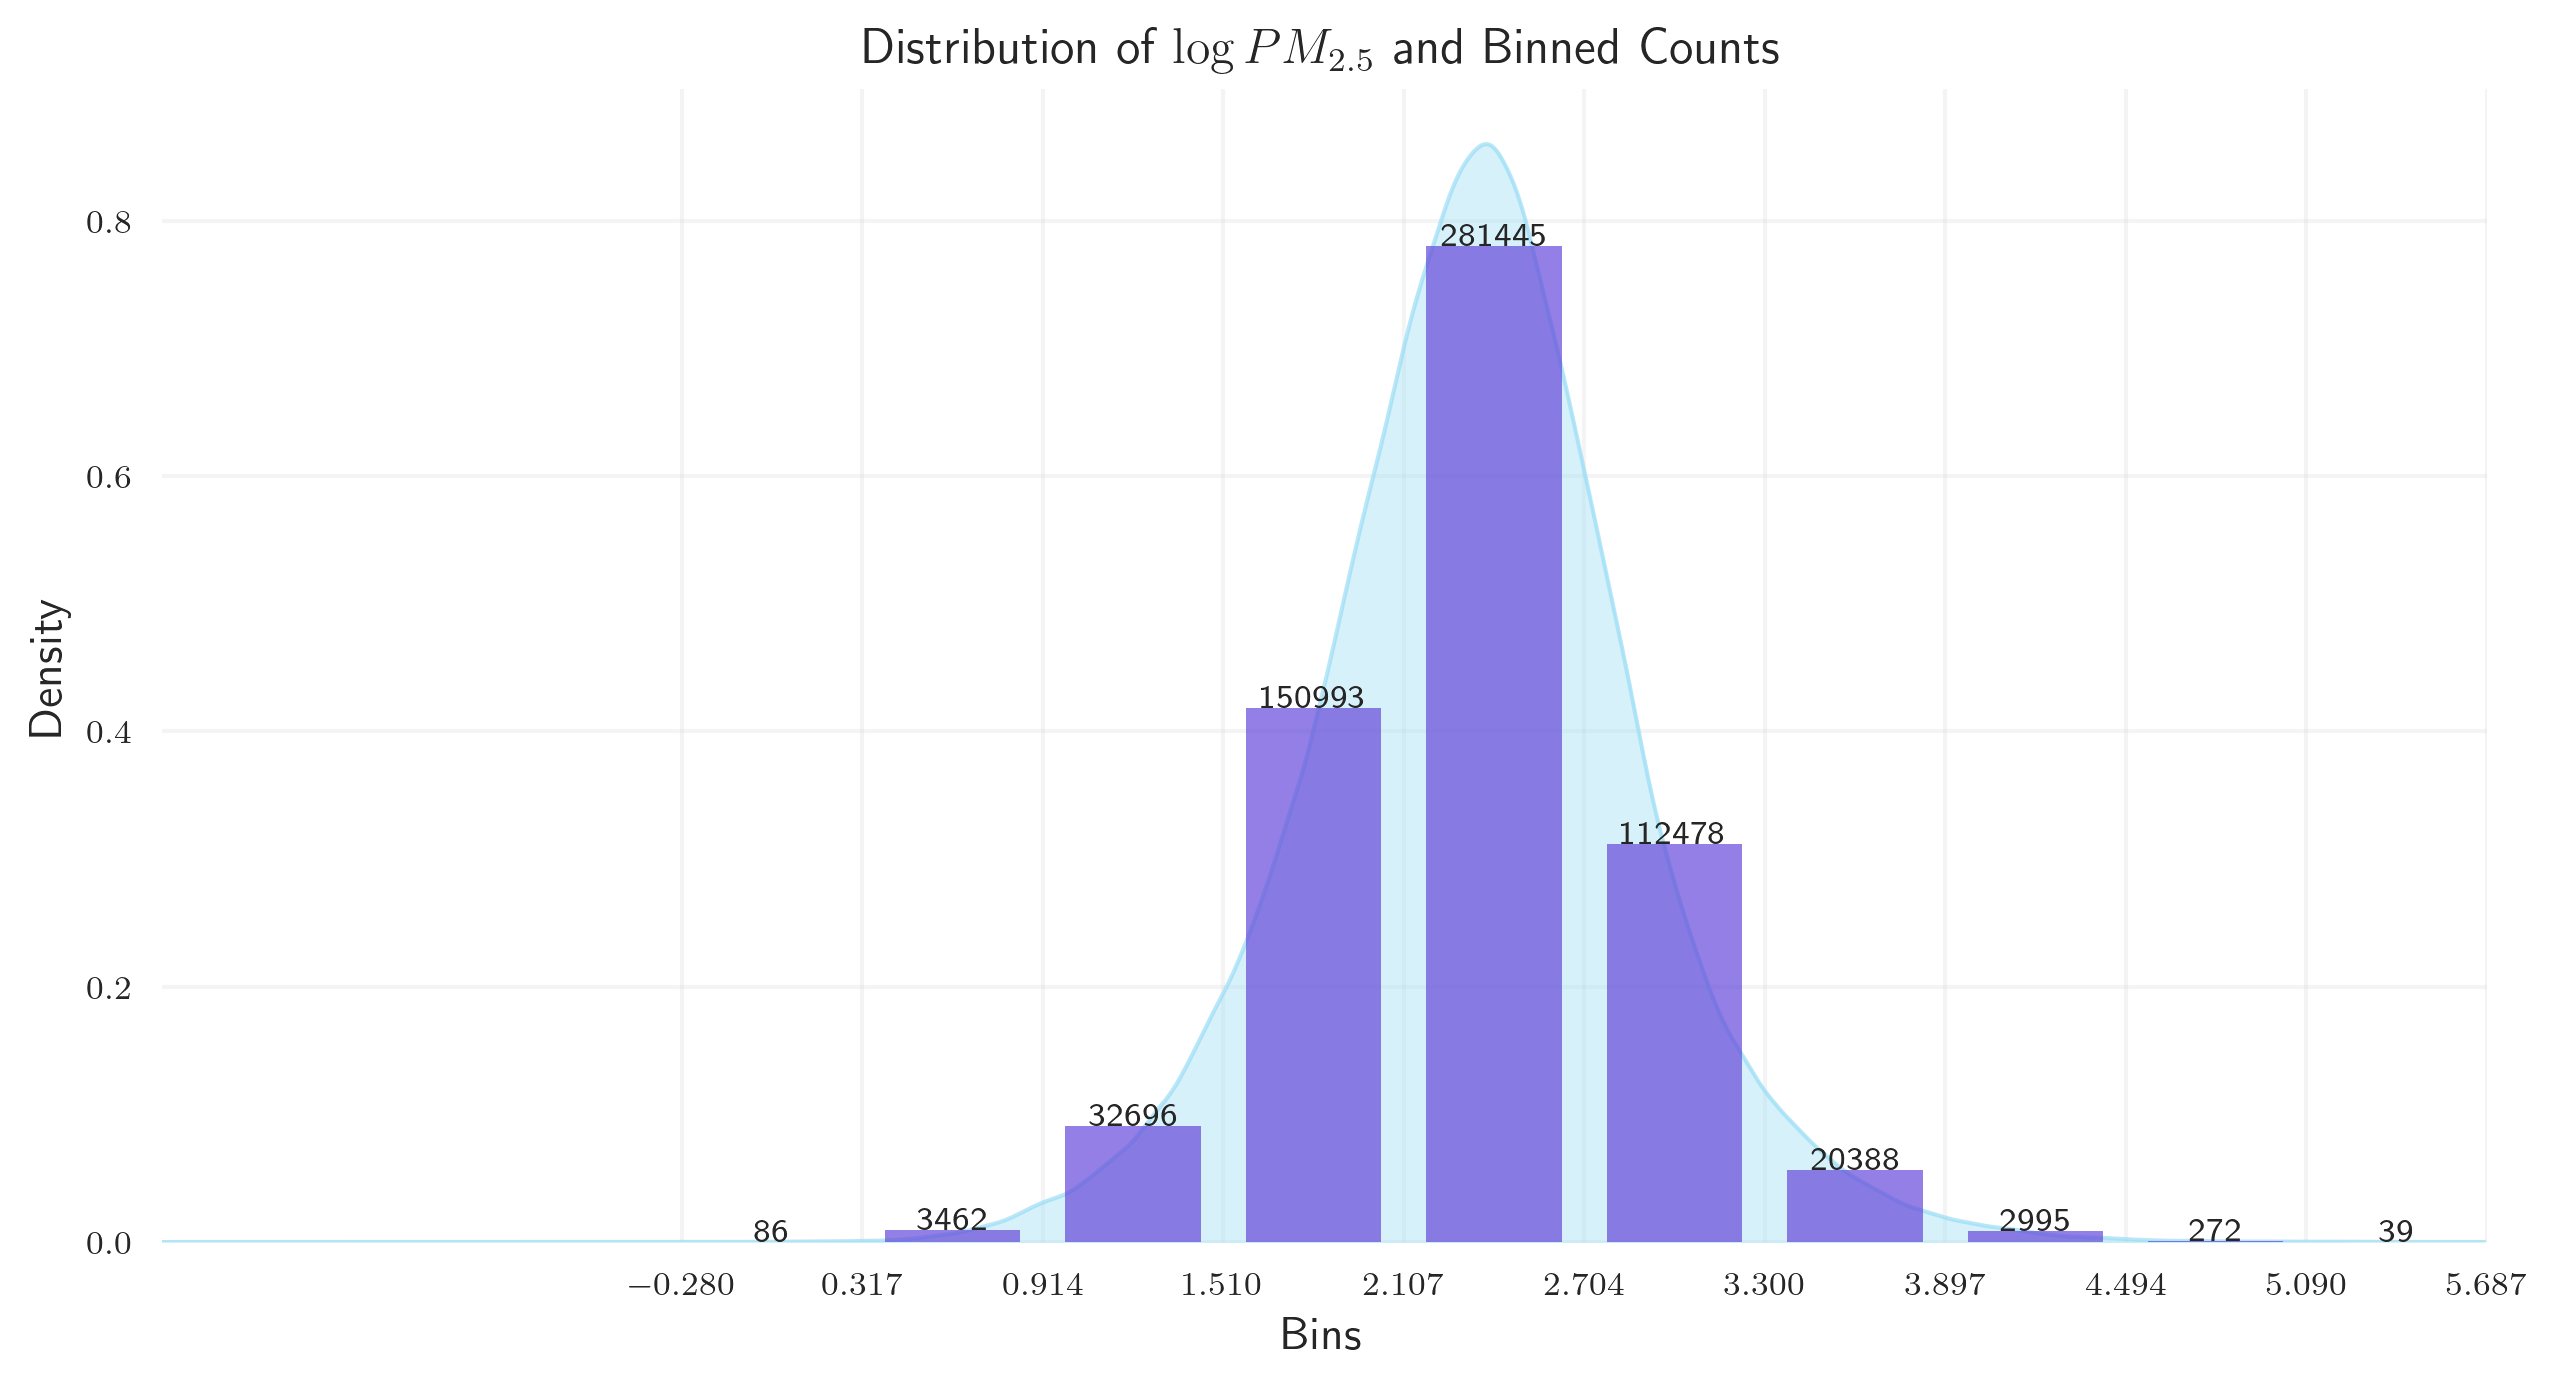

In [58]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(train, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $\log PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-2, 
                       ax=ax)

plt.savefig(os.path.join(paths.figures, 'distribution.png'))

## Results

In [59]:
val_results_file = os.path.join(paths.base, 'validation_predictions.csv')

if os.path.exists(val_results_file):
    predictions = pd.read_csv(val_results_file).set_index('time')
else:
    preds = mc.predict(x_val)
    predictions = pd.DataFrame(preds, index=x_val.index)
    predictions = pd.concat([predictions, pd.DataFrame({'True Value': y_val}, index=x_val.index)], axis=1)
    predictions.to_csv(val_results_file)

In [61]:
from utils import summarize_scores, scores_from_model_collection_predictions

predictions = predictions[order]
scores = scores_from_model_collection_predictions(predictions).reindex(order)

linear_preds = predictions[linear]
tree_preds = predictions[trees]
nn_preds = predictions[nn]

In [62]:
print(scores.to_csv())

Model,R2,MAE,RMSE
Linear Regression,0.539895669842507,0.2891291034997694,0.38125054316726337
Elastic Net,0.5410667107316194,0.2887191662395103,0.380765061520716
Polynomial,0.5963654589449274,0.27070493360190234,0.35708900056076864
Bayesian Ridge,0.5398974066193618,0.28912850259185946,0.3812498236046548
SVR,0.5370575809796432,0.28850686457007757,0.3824245806622273
Ada Boost,0.5775427288448669,0.28635282595867195,0.3653202158058251
Random Forest,0.6706009775151935,0.2432578768815955,0.32258447614862656
Extra Trees,0.6639367342324407,0.24644809465887882,0.3258313235371254
Gradient Boost,0.6608250173908581,0.2466019878287168,0.3273363357320475
XGBoost,0.6349835787041096,0.2559092044830322,0.33957719802856445
MLP,0.678374866616813,0.24045933243849624,0.31875521625243314
MLP1,0.6769757198829376,0.2413385564372179,0.31944779480082325
MLP2,0.6731337685799615,0.2433519024389757,0.3213418863567445
MLP3,0.676793114114864,0.24248262443753876,0.31953807403357654
MLP4,0.6737024653820012,0.2428986816

In [167]:
class PredictionAggregation:
    def __init__(self, predictions):
        self.predictions = predictions
        
    def predict(self, x):
        return self.predictions

In [168]:
from sklearn.linear_model import LinearRegression

def quad_prediction_plot(y_true, y_predictions, 
                         width=504,
                         legend_fontsize = 12,
                         cmap='viridis',
                         unity_color = '#A86CAD', 
                         fit_color = '#FCA481', 
                         r2_ax_locx = .1, 
                         r2_ax_locy = .8):
    fig, axes = plt.subplots(2, 2, figsize=set_size(width))
                             
    for y_hat, ax in zip(y_predictions, axes.ravel()):
        fit = LinearRegression().fit(y_true, y_hat)

        fit_r2 = fit.score(y_true, y_hat)
        equation = f'y = {fit.coef_[0]:.2f} x + {fit.intercept_:.2f}'

        line = np.arange(0, y_true.max(), 1)

        ax.plot(line, line, '--', color=unity_color, lw=1, label='unity')
        ax.plot(line, fit.predict(line.reshape(-1, 1)), color=fit_color, lw=1, label=equation)

        hb = ax.hexbin(y_true, y_hat, alpha=1.0, cmap=cmap)
        cb = fig.colorbar(hb, ax=ax)

        mae = mean_absolute_error(y_true, y_hat)
        rmse = mean_squared_error(y_true, y_hat, squared=False)

#         fontdict = {'fontsize': legend_fontsize}
#         ax.text(r2_ax_locx, r2_ax_locy, 
#                 fr'$R^2 ={fit_r2:.2f}$', 
#                 transform=ax.transAxes, 
#                 fontdict=fontdict)
#         ax.text(r2_ax_locx, r2_ax_locy - .05, 
#                 fr'$RMSE ={rmse:.2f}$', 
#                 transform=ax.transAxes, 
#                 fontdict=fontdict)
#         ax.text(r2_ax_locx, r2_ax_locy - .1, 
#                 fr'$MAE ={mae:.2f}$', 
#                 transform=ax.transAxes, 
#                 fontdict=fontdict)
    
    return fig, axes

In [169]:
# averaged_predictions = [linear_preds.mean(axis=1), tree_preds.mean(axis=1), nn_preds.mean(axis=1), stack.predict(x_val.copy())]

In [170]:
# quad_prediction_plot(y_val.values.reshape(-1, 1), averaged_predictions, cmap=announce, r2_ax_locx=1.25, r2_ax_locy=1.3)

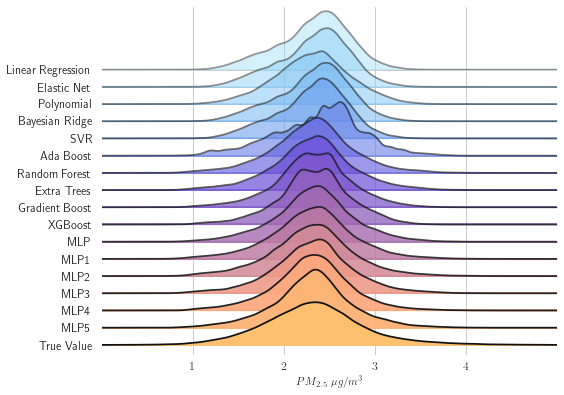

In [63]:
import joypy

fig, axes = joypy.joyplot(predictions, fade=True, colormap=announce, x_range=(0, 5), grid=True)

axes[-1].set_xlabel('$PM_{2.5} ~ \mu g/m^3$')

fig.savefig(os.path.join(paths.figures, 'densities.svg'), format='svg', bbox_inches = "tight")

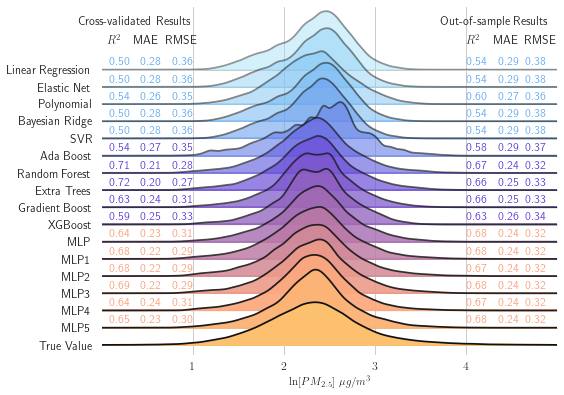

In [64]:
import joypy

fig, axes = joypy.joyplot(predictions, fade=True, colormap=announce, x_range=(0, 5), grid=True)

axes[-1].set_xlabel('$\ln[PM_{2.5}] ~ \mu g/m^3$')

ax = axes[0]

# CV labels
ax.text(0.07, .75, 'Cross-validated Results', ha='center', transform=ax.transAxes)
ax.text(0.01, .5, '$R^2$', ha='left', transform=ax.transAxes)
ax.text(0.07, .5, 'MAE', ha='left', transform=ax.transAxes)
ax.text(0.14, .5, 'RMSE', ha='left', transform=ax.transAxes)

# Real Labels
ax.text(0.86, .75, 'Out-of-sample Results', ha='center', transform=ax.transAxes)
ax.text(0.8, .5, '$R^2$', ha='left', transform=ax.transAxes)
ax.text(0.86, .5, 'MAE', ha='left', transform=ax.transAxes)
ax.text(0.93, .5, 'RMSE', ha='left', transform=ax.transAxes)

for ax in axes[:-2]:
    model = ax.get_yticklabels()[0].get_text()
    perf = scores.loc[model]
    if model in linear:
        text_color = linear_color
    elif model in trees:
        text_color = tree_color
    else:
        text_color = nn_color
        
    ax.text(0.8, .2, f'{perf["R2"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    ax.text(0.87, .2, f'{perf["MAE"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    ax.text(0.93, .2, f'{perf["RMSE"]:.2f}', ha='left', transform=ax.transAxes, color=text_color)
    
    cv_res = cv_results.loc[model]
    ax.text(0.06, .2, f'{cv_res["R2"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
    ax.text(0.13, .2, f'{cv_res["MAE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)
    ax.text(0.2, .2, f'{cv_res["RMSE"]:.2f}', ha='right', transform=ax.transAxes, color=text_color)

fig.savefig(os.path.join(paths.figures, 'densities-with-scores.svg'), format='svg')

In [65]:
models = [model for model in mc.cross_val_scores_.keys()]
fits, error = [], []
for model in models:
    res = mc.cross_val_scores_[model]
    fits.append(res['fit_time'].mean())
    error.append(np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])))
    
fit_df = pd.DataFrame({'Fit Time': fits, 'Error': error}, index=models).reindex(order)
fit_df.drop('True Value', axis=0, inplace=True)

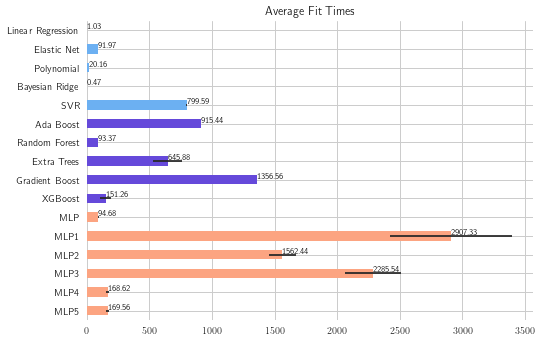

In [66]:
fig, ax = plt.subplots()

fit_df.plot(kind = "barh", y = "Fit Time", 
            legend = False, 
            title = "Average Fit Times", 
            xerr = "Error", color=[linear_color]*5 +[tree_color]*5 + [nn_color]*6,
            ax=ax)


for patch in ax.patches:
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{patch.get_width():0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
ax.invert_yaxis()

fig.savefig(os.path.join(paths.figures, 'fit_times.svg'), format='svg', bbox_inches='tight')

In [67]:
average_fit_times = {model: res['fit_time'].mean() for model, res in mc.cross_val_scores_.items()}
fit_times_error = {model: np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])) for model, res in mc.cross_val_scores_.items()}

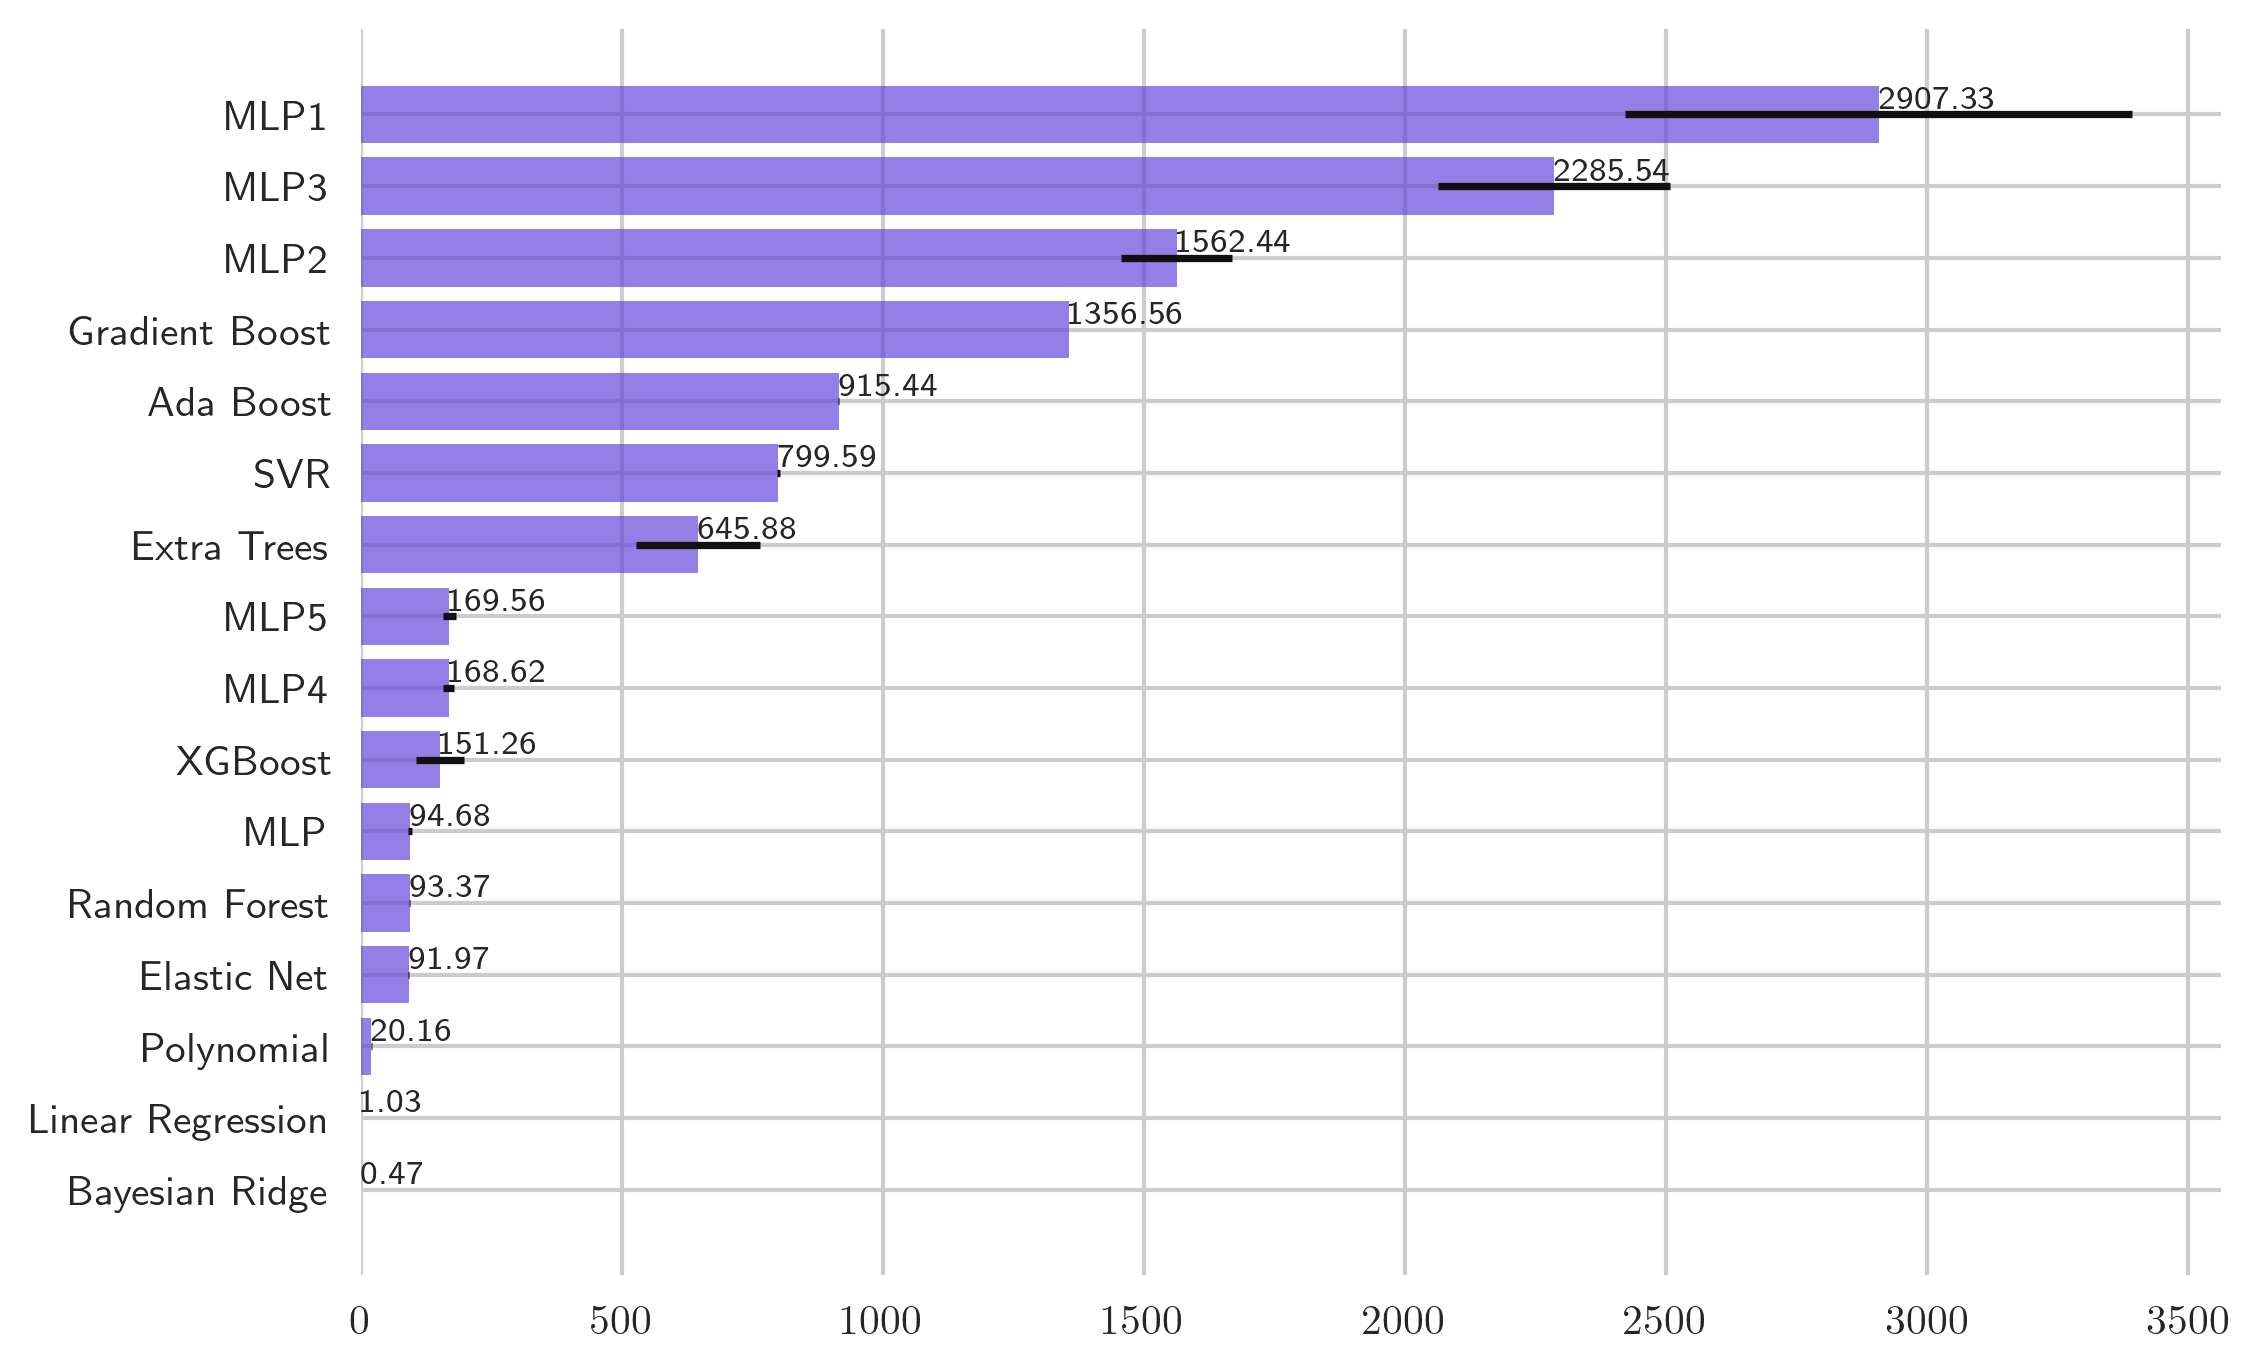

In [68]:
fig, ax = plt.subplots(dpi=300)

labels, values = map(np.array, zip(*average_fit_times.items()))
sort = np.argsort(values.flatten())

labels, values = labels[sort], values[sort]
xerr = np.array(list(fit_times_error.values()))[sort]

patches = ax.barh(labels, 
                  values.flatten(), 
                  xerr=xerr,
                  alpha=0.7,
                  color='#6549DA')

for idx, patch in enumerate(patches):
    which = labels[idx]
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{average_fit_times[which]:0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
fig.savefig(os.path.join(paths.figures, 'fit_times.svg'), format='svg', bbox_inches='tight')

## Gridded Results

In [69]:
gridded_results_file = os.path.join(paths.base, 'validation_results.nc4')

if os.path.exists(gridded_results_file):
    with xr.open_dataset(gridded_results_file) as results:
        results.load()
else:
    results = predictions.copy()
    results.index = pd.to_datetime(results.index)
    results[['lat', 'lon']] = val[['lat', 'lon']]
    results = results.reset_index().set_index(['lat', 'lon', 'time']).to_xarray()
    results = results.apply(np.exp)
    results.to_netcdf(gridded_results_file)

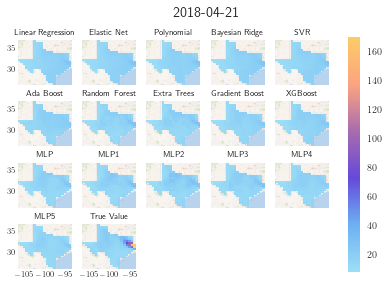

In [70]:
true = results['True Value']
max_pm_occurence = true.where(true==true.max(), drop=True).squeeze().time.values
ds = results.sel(time=max_pm_occurence)

fig_title = np.datetime_as_string(max_pm_occurence, unit='D')

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig(os.path.join(experiment, 'figures', 'max_pm_with_predictions.svg'), format='svg', bbox_inches='tight')

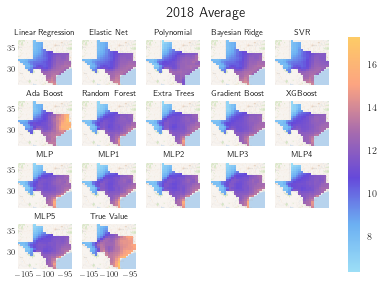

In [71]:
avg_2018 = results.resample(time="Y").mean().sel(time='2018')

fig_title = '2018 Average'

fig, axes = map_predicted(avg_2018, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2018_average_predictions.svg'), format='svg', bbox_inches='tight')

In [72]:
def difference_from_true(ds):
    df = ds.to_dataframe().reset_index('time').dropna().drop(['time'], axis=1)
    true_series = df['True Value']
    df.drop(['True Value'], axis=1, inplace=True)
    
    cols = df.columns
    df[cols] = df[cols].sub(true_series.squeeze(), axis=0)
    return df.to_xarray()

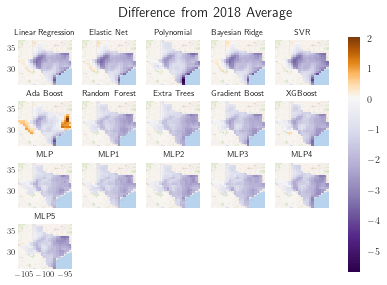

In [73]:
from matplotlib import cm
from palettable.colorbrewer.diverging import PuOr_11

fig_title = 'Difference from 2018 Average'

difference_from_true_2018 = difference_from_true(avg_2018)

fig, axes = map_predicted(difference_from_true_2018, nrows=4, ncols=5, colormap=PuOr_11.mpl_colormap.reversed(), two_slope_norm=True)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2018_difference_from_true_mean.svg'), format='svg', bbox_inches='tight')

In [74]:
ds = grid_predictions.resample(time="Y").mean().apply(np.exp)

fig_title = 'Difference from 2011 Mean'

grid_model_difference = difference_from_true(ds)

fig, axes = map_predicted(grid_model_difference, nrows=4, ncols=5, colormap=PuOr_11s.mpl_colormap)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2011_grid-by-grid_difference.svg'), format='svg', bbox_inches='tight')

NameError: name 'grid_predictions' is not defined